In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cinnabar.plotting import _master_plot
from cinnabar.stats import bootstrap_statistic
import seaborn as sns
import numpy as np
sns.set_context("talk")

# setup the colours to use in the plots
openfe_color = '#8A2283'
fep_plus_color = '#50CAF5'
fep_plus_text_color = "#0078E4"  # slightly darker blue for text


In [2]:
# load the basic edge data
edge_data_openfe = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_edge_data.csv")
fep_plus_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/schrodinger_21_4_results/combined_schrodinger_ddg.csv")
# load the delta G data
fep_plus_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/schrodinger_21_4_results/combined_schrodinger_dg.csv")
dg_data_openfe = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_calculated_dg_data.csv")

In [3]:
# drop edges with no experimental data and that are marked as failed
all_openfe_edges = edge_data_openfe[(edge_data_openfe["exp DDG (kcal/mol)"].notna()) & (edge_data_openfe["failed"] != True)].copy(deep=True).reset_index(drop=True)
all_openfe_edges


,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,DDG_bind (kcal/mol),stdev DDG_bind (kcal/mol)
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,27.245596,0.113900,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2,0.456528,0.253792
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,-21.401634,0.074439,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2,-2.734255,0.244470
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,17.934588,0.088183,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2,-2.866959,0.355077
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,-3.680717,0.204893,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk,0.091906,0.229812
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,4.873596,0.068123,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk,-1.613313,0.121454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,5.025639,0.083096,47.049469,68.496689,0.104164,NaN,merck,pfkfb3,0.817963,0.325819
1177,65,29,0.704688,0,1.000000,0.155796,0.895401,0.484258,30,0,...,-83.240725,0.102459,29.012836,53.727703,0.160825,NaN,merck,pfkfb3,0.485801,0.245501
1178,29,64,0.778801,0,1.000000,0.155630,0.895401,0.462020,30,1,...,86.337561,0.101216,46.250511,68.017464,0.164021,NaN,merck,pfkfb3,-0.323246,0.434290
1179,47,46,0.548812,0,1.000000,0.202290,0.735485,0.305883,27,2,...,-11.214751,0.046477,43.071308,66.045006,0.131496,NaN,merck,pfkfb3,-0.649200,0.090989


In [4]:
# add the FEP+ data to the all_dg_data df
fep_ccc, fep_plus_error = [], []
for _, row in dg_data_openfe.iterrows():
    # find the matching row in the fep_plus_dg_data
    matching_ds = fep_plus_dg_data[(fep_plus_dg_data["system name"] == row["system name"]) & (fep_plus_dg_data["system group"] == row["system group"])]
    matching_row = matching_ds[matching_ds["Ligand name"] == row["ligand name"]].iloc[0]
    fep_ccc.append(matching_row["Pred. dG (kcal/mol)"])
    fep_plus_error.append(matching_row["Pred. dG std. error (kcal/mol)"])
    # make sure that the exp data is close 
    assert abs(matching_row["Exp. dG (kcal/mol)"] - row["Exp DG (kcal/mol)"]) < 0.1, f"Mismatch in exp data for {row['system name']} {row['ligand name']}"

# add back to the df
dg_data_openfe["FEP+ DG (kcal/mol)"] = fep_ccc
dg_data_openfe["FEP+ DG std. error (kcal/mol)"] = fep_plus_error


In [23]:
dg_data_openfe.columns

Index(['ligand name', 'DG (kcal/mol)', 'uncertainty (kcal/mol)',
       'Exp DG (kcal/mol)', 'Exp dDG (kcal/mol)', 'partner_id', 'dataset_name',
       'system group', 'system name', 'DG MMGBSA', 'FEP+ DG (kcal/mol)',
       'FEP+ DG std. error (kcal/mol)'],
      dtype='object')

In [29]:
# calculate the pairwise (all-to-all, without symmetry) DDG for each system
dg_system_metrics = []  
for system in dg_data_openfe["system group"].unique():
    # get the edges for these systems
    system_df = dg_data_openfe[dg_data_openfe["system group"] == system].copy(deep=True).reset_index(drop=True)
    targets = system_df["system name"].unique()
    for target in targets:
        # get the edges for this target
        target_df = system_df[(system_df["system name"] == target)].copy(deep=True).reset_index(drop=True)
        target_data = {"System": target, "Class": system, "N_ligs": len(target_df)}
        ligands = target_df["ligand name"].unique()
        # calculate the bootstrap metrics
        for prediction, error, label in [("DG (kcal/mol)", "uncertainty (kcal/mol)", "OpenFE"), ("FEP+ DG (kcal/mol)", "FEP+ DG std. error (kcal/mol)", "FEP+"), ("DG MMGBSA", "", "MMGBSA")]:
            exp_ddgs, exp_error, prediction_ddgs, prediction_error = [], [], [], []
            for i, ligand_a in enumerate(ligands):
                for j, ligand_b in enumerate(ligands):
                    if i >= j:
                        continue
                    # get the exp ddg for this pair
                    ligand_a_exp = target_df[target_df["ligand name"] == ligand_a]["Exp DG (kcal/mol)"].values[0]
                    ligand_b_exp = target_df[target_df["ligand name"] == ligand_b]["Exp DG (kcal/mol)"].values[0]
                    exp_ddg = ligand_b_exp - ligand_a_exp
                    exp_ddgs.append(exp_ddg)
                    exp_error_a = target_df[target_df["ligand name"] == ligand_a]["Exp dDG (kcal/mol)"].values[0]
                    exp_error_b = target_df[target_df["ligand name"] == ligand_b]["Exp dDG (kcal/mol)"].values[0]
                    exp_error.append((exp_error_a ** 2 + exp_error_b ** 2) ** 0.5)
                    # get the prediction ddg for this pair
                    ligand_a_pred = target_df[target_df["ligand name"] == ligand_a][prediction].values[0]
                    ligand_b_pred = target_df[target_df["ligand name"] == ligand_b][prediction].values[0]
                    prediction_ddg = ligand_b_pred - ligand_a_pred
                    prediction_ddgs.append(prediction_ddg)
                    if error != "":
                        prediction_error_a = target_df[target_df["ligand name"] == ligand_a][error].values[0]
                        prediction_error_b = target_df[target_df["ligand name"] == ligand_b][error].values[0]
                        prediction_error.append((prediction_error_a ** 2 + prediction_error_b ** 2) ** 0.5)
                    else:
                        prediction_error.append(0.0)
            # convert to numpy arrays
            exp = np.array(exp_ddgs)
            exp_error = np.array(exp_error)
            prediction = np.array(prediction_ddgs)
            prediction_error = np.array(prediction_error)
            # manual bootstrap the ddg values
            nbootstrap = 1000
            rmse = np.zeros(nbootstrap)
            for i in range(nbootstrap):
                # sample with replacement
                indices = np.random.choice(len(exp), size=len(exp), replace=True)
                sampled_exp = exp[indices]
                sampled_prediction = prediction[indices]
                # calculate the RMSE
                rmse[i] = np.sqrt(np.mean((sampled_prediction - sampled_exp) ** 2))
            # calculate the RMSE sample value and CI
            s = {
                "mle": np.sqrt(np.mean((prediction - exp) ** 2)),
                "low": np.percentile(rmse, 2.5),
                "high": np.percentile(rmse, 97.5)
            }
            target_data[f"{label} RMSE"] = s["mle"]
            target_data[f"{label} RMSE_lower"] = s["low"]
            target_data[f"{label} RMSE_upper"] = s["high"]
        # add the data to a new dataframe
        dg_system_metrics.append(target_data)
# create a new dataframe with all of the metrics calculated for each system
dg_system_metrics = pd.DataFrame(dg_system_metrics)
dg_system_metrics.sort_values(by=['Class', 'OpenFE RMSE'], inplace=True)
dg_system_metrics
        

,System,Class,N_ligs,OpenFE RMSE,OpenFE RMSE_lower,OpenFE RMSE_upper,FEP+ RMSE,FEP+ RMSE_lower,FEP+ RMSE_upper,MMGBSA RMSE,MMGBSA RMSE_lower,MMGBSA RMSE_upper
11,tyk2,charge_annihilation_set,5,0.638636,0.430815,0.821695,1.127803,0.616255,1.456211,5.383907,3.632207,6.947978
1,dlk,charge_annihilation_set,5,0.892505,0.606570,1.153006,0.453277,0.311549,0.573346,6.240203,4.048444,8.072878
0,cdk2,charge_annihilation_set,3,1.026392,0.254872,1.364974,0.371752,0.245560,0.490000,7.544539,1.750000,9.990000
5,irak4_s3,charge_annihilation_set,4,1.039046,0.663522,1.325849,1.230847,0.693823,1.641732,6.192474,3.762721,8.387335
4,irak4_s2,charge_annihilation_set,5,1.091114,0.741318,1.390044,1.259365,0.849980,1.623521,10.104378,6.893629,13.309806
3,ephx2,charge_annihilation_set,4,1.130430,0.710406,1.511697,1.231659,0.795278,1.647088,21.043052,11.840229,27.759198
6,itk,charge_annihilation_set,4,1.227403,0.757225,1.669814,1.065543,0.654091,1.459229,4.909006,3.093884,6.580274
7,jak1,charge_annihilation_set,6,1.250547,0.915449,1.561486,0.708054,0.490770,0.912486,5.763844,4.129630,7.265434
10,thrombin,charge_annihilation_set,6,1.435536,1.023275,1.806335,1.452006,1.017694,1.882586,11.131708,8.080447,13.531746
2,egfr,charge_annihilation_set,5,1.965656,1.357066,2.500552,1.193482,0.838698,1.502708,1.943440,1.308075,2.566180


In [30]:
# how many systems have RMSE with openfe less that 1 kcal/mol compared to FEP+?
openfe_less_than_1 = dg_system_metrics[dg_system_metrics["OpenFE RMSE"] < 1].copy(deep=True).reset_index(drop=True)
fep_plus_less_than_1 = dg_system_metrics[dg_system_metrics["FEP+ RMSE"] < 1].copy(deep=True).reset_index(drop=True)
print(f"Number of systems with OpenFE RMSE < 1 kcal/mol: {len(openfe_less_than_1)}")
print(f"Number of systems with FEP+ RMSE < 1 kcal/mol: {len(fep_plus_less_than_1)}")

Number of systems with OpenFE RMSE < 1 kcal/mol: 10
Number of systems with FEP+ RMSE < 1 kcal/mol: 19


In [31]:
# calculate the weighted RMSE for OpenFE and FEP+ with 95% CI from bootstrapping add to the dataframe
import numpy as np
nboots = 1000
openfe_rmse, fep_plus_rmse, mmgbsa_rmse = np.zeros(nboots), np.zeros(nboots), np.zeros(nboots)
for i in range(nboots):
    # bootstrap the data
    bootstrapped_data = dg_system_metrics.sample(n=len(dg_system_metrics), replace=True)
    openfe_rmse[i] = np.sqrt(np.sum(bootstrapped_data["OpenFE RMSE"] ** 2 * bootstrapped_data["N_ligs"]) / np.sum(bootstrapped_data["N_ligs"]))
    fep_plus_rmse[i] = np.sqrt(np.sum(bootstrapped_data["FEP+ RMSE"] ** 2 * bootstrapped_data["N_ligs"]) / np.sum(bootstrapped_data["N_ligs"]))
    mmgbsa_rmse[i] = np.sqrt(np.sum(bootstrapped_data["MMGBSA RMSE"] ** 2 * bootstrapped_data["N_ligs"]) / np.sum(bootstrapped_data["N_ligs"]))
    

row_data = {
    "System": "Weighted",
    "Class": "Overall",
    "N_ligs": len(dg_system_metrics),
    "OpenFE RMSE": np.sqrt(np.sum(dg_system_metrics["OpenFE RMSE"] ** 2 * dg_system_metrics["N_ligs"]) / np.sum(dg_system_metrics["N_ligs"])),
    "OpenFE RMSE_lower": np.percentile(openfe_rmse, 2.5),
    "OpenFE RMSE_upper": np.percentile(openfe_rmse, 97.5),
    "FEP+ RMSE": np.sqrt(np.sum(dg_system_metrics["FEP+ RMSE"] ** 2 * dg_system_metrics["N_ligs"]) / np.sum(dg_system_metrics["N_ligs"])),
    "FEP+ RMSE_lower": np.percentile(fep_plus_rmse, 2.5),
    "FEP+ RMSE_upper": np.percentile(fep_plus_rmse, 97.5),
    "MMGBSA RMSE": np.sqrt(np.sum(dg_system_metrics["MMGBSA RMSE"] ** 2 * dg_system_metrics["N_ligs"]) / np.sum(dg_system_metrics["N_ligs"])),
    "MMGBSA RMSE_lower": np.percentile(mmgbsa_rmse, 2.5),
    "MMGBSA RMSE_upper": np.percentile(mmgbsa_rmse, 97.5),  
}
# add the row to the dataframe using concat
dg_system_metrics = pd.concat([dg_system_metrics, pd.DataFrame([row_data])], ignore_index=True)
dg_system_metrics

,System,Class,N_ligs,OpenFE RMSE,OpenFE RMSE_lower,OpenFE RMSE_upper,FEP+ RMSE,FEP+ RMSE_lower,FEP+ RMSE_upper,MMGBSA RMSE,MMGBSA RMSE_lower,MMGBSA RMSE_upper
0,tyk2,charge_annihilation_set,5,0.638636,0.430815,0.821695,1.127803,0.616255,1.456211,5.383907,3.632207,6.947978
1,dlk,charge_annihilation_set,5,0.892505,0.606570,1.153006,0.453277,0.311549,0.573346,6.240203,4.048444,8.072878
2,cdk2,charge_annihilation_set,3,1.026392,0.254872,1.364974,0.371752,0.245560,0.490000,7.544539,1.750000,9.990000
3,irak4_s3,charge_annihilation_set,4,1.039046,0.663522,1.325849,1.230847,0.693823,1.641732,6.192474,3.762721,8.387335
4,irak4_s2,charge_annihilation_set,5,1.091114,0.741318,1.390044,1.259365,0.849980,1.623521,10.104378,6.893629,13.309806
5,ephx2,charge_annihilation_set,4,1.130430,0.710406,1.511697,1.231659,0.795278,1.647088,21.043052,11.840229,27.759198
6,itk,charge_annihilation_set,4,1.227403,0.757225,1.669814,1.065543,0.654091,1.459229,4.909006,3.093884,6.580274
7,jak1,charge_annihilation_set,6,1.250547,0.915449,1.561486,0.708054,0.490770,0.912486,5.763844,4.129630,7.265434
8,thrombin,charge_annihilation_set,6,1.435536,1.023275,1.806335,1.452006,1.017694,1.882586,11.131708,8.080447,13.531746
9,egfr,charge_annihilation_set,5,1.965656,1.357066,2.500552,1.193482,0.838698,1.502708,1.943440,1.308075,2.566180


In [32]:
# paired significance test on the RMSE values not including the weighted RMSE
# filter out the weighted RMSE row
dg_system_metrics_filtered = dg_system_metrics[dg_system_metrics["System"] != "Weighted\nRMSE"].copy(deep=True).reset_index(drop=True)
# perform the wilcoxon signed-rank test
from scipy.stats import wilcoxon
stat, p_value = wilcoxon(dg_system_metrics_filtered["OpenFE RMSE"], dg_system_metrics_filtered["FEP+ RMSE"])
print(f"Paired wilcoxon test between OpenFE and FEP+ RMSE: statistic = {stat:.3f}, p-value = {p_value}")

Paired wilcoxon test between OpenFE and FEP+ RMSE: statistic = 180.000, p-value = 1.0301527489096879e-07


In [33]:
# report the range of the RMSE values for OpenFE and FEP+ not including the weighted RMSE
openfe_rmse_range = dg_system_metrics_filtered["OpenFE RMSE"].agg(["min", "max"])
fep_plus_rmse_range = dg_system_metrics_filtered["FEP+ RMSE"].agg(["min", "max"])
print(f"OpenFE RMSE range: {openfe_rmse_range['min']:.3f} - {openfe_rmse_range['max']:.3f} kcal/mol")
print(f"FEP+ RMSE range: {fep_plus_rmse_range['min']:.3f} - {fep_plus_rmse_range['max']:.3f} kcal/mol")

OpenFE RMSE range: 0.639 - 4.912 kcal/mol
FEP+ RMSE range: 0.358 - 1.829 kcal/mol


['tyk2', 'dlk', 'cdk2', 'irak4 s3', 'irak4 s2', 'ephx2', 'itk', 'jak1', 'thrombin', 'egfr', 'ptp1b', 'jnk1', 'mup1', 'hsp90 single ring', 't4 lysozyme', 'jak2 set1', 'jak2 set2', 'mcl1', 'hsp90 2rings', 'p38', 'liga', 'thrombin', 'tyk2', 'cdk2', 'jnk1', 'ptp1b', 'bace', 'mcl1', 'p38', 'ciordia retro', 'keranen p2', 'bace ciordia prosp', 'bace p3 arg368 in', 'renin', 'hne', 'eg5', 'pfkfb3', 'syk', 'cdk8', 'cmet', 'tnks2', 'hif2a', 'shp2', 'cdk8', 'galectin', 'btk', 'faah', 'hiv1 protease', 'bace1', 'factor xa', 'taf12', 'brd4', 'urokinase', 'chk1', 'thrombin', 'hsp90 woodhead', 'scyt dehyd', 'hsp90 kung', 'Weighted']


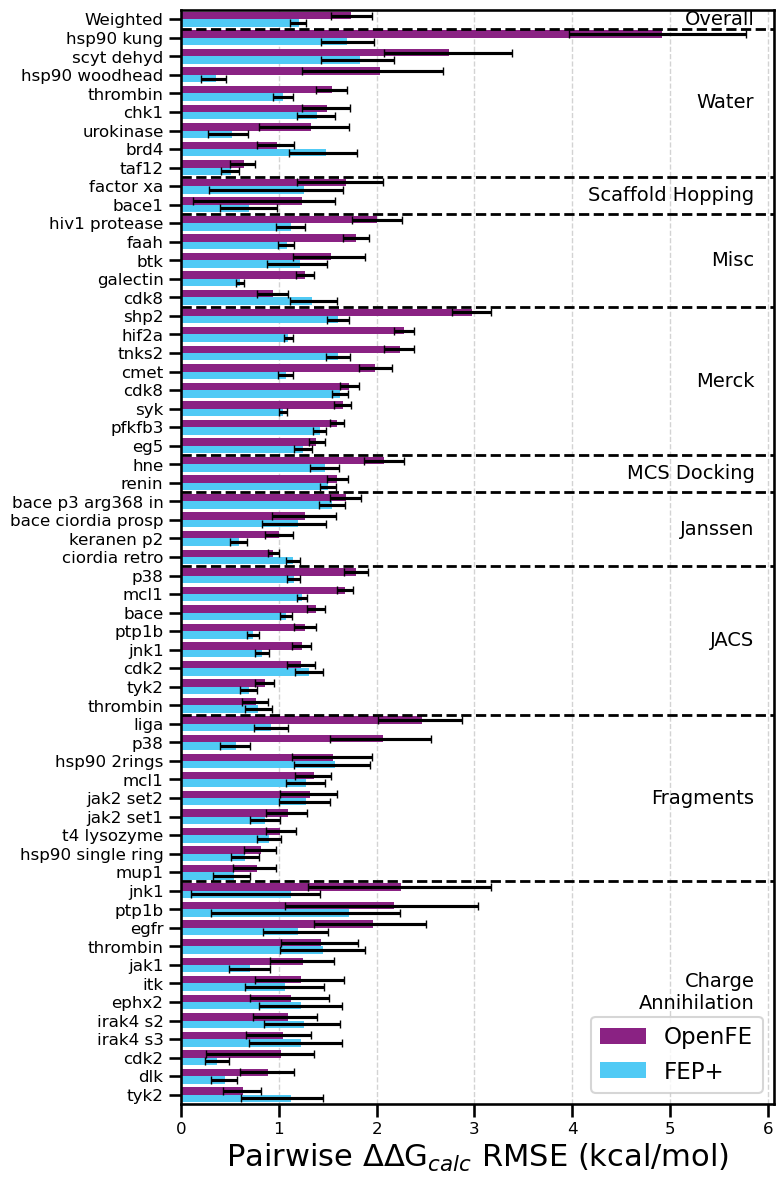

In [148]:
# plot the pairwise RMSE for OpenFE and FEP+ with 95% CI for each system and the weighted RMSE, vertically
def plot_vertical_rmse_comparison(system_metrics, label1, label2, filename, colour1, colour2):
    x = np.arange(len(system_metrics))

    fig, ax = plt.subplots(figsize=(8, 12))
    bar_width = 0.4

    # Plot bars with error bars
    rmse_err_openfe = [system_metrics[label1 + ' RMSE'] - system_metrics[label1 + ' RMSE_lower'], system_metrics[label1 + ' RMSE_upper'] - system_metrics[label1 + ' RMSE']]
    rmse_err_plus = [system_metrics[label2 + ' RMSE'] - system_metrics[label2 + ' RMSE_lower'], system_metrics[label2 + ' RMSE_upper'] - system_metrics[label2 + ' RMSE']]

    ax.barh(x + bar_width/2, system_metrics[label1 + ' RMSE'], xerr=rmse_err_openfe, height=bar_width, label=label1,
        color=colour1, capsize=3)
    ax.barh(x - bar_width/2, system_metrics[label2 + ' RMSE'], xerr=rmse_err_plus, height=bar_width, label=label2,
        color=colour2, capsize=3)

    # Set labels and ticks
    ax.set_yticks(x)
    names = system_metrics['System'].str.replace("_", " ")
    # trim off names that are too long
    names = [name.replace("prospective", "prosp") for name in names]
    print(names)
    ax.set_yticklabels(names, fontsize=12)
    ax.set_xlabel(r"Pairwise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontsize=22)
    ax.legend()

    # Add Ross et al collection names to the right of the bars
    unique_classes = system_metrics['Class'].unique()
    unique_classes = [cls for cls in unique_classes if cls != "Overall"]
    unique_classes.append("Overall")
    class_bounds = system_metrics.groupby('Class').size().cumsum().to_dict()
    class_bounds["Overall"] = len(system_metrics) + 1

    for cls, bound in class_bounds.items():
        if cls == "Overall":
            continue
        class_bounds[cls] = bound - 1
    class_start = 0

    # convert the names to more readable format
    class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold Hopping", "water_set": "Water", "mcs_docking_set": "MCS Docking"}
    for i, cls in enumerate(unique_classes):
        cls_name = class_conversion.get(cls, cls)
        end = class_bounds[cls]
        if cls != "charge_annihilation_set":
            ax.axhline(class_start - 0.5, linestyle='--', linewidth=2, color="black")
        if cls == "Overall":
                # move the text to fit in the space
                center = class_start
        else:
            center = (class_start + end - 1) / 2
        ax.text(ax.get_xlim()[1] - 0.2, center, cls_name, va='center', ha='right', fontsize=14, rotation=0)
        class_start = end

    # add vertical light grey dashed lines at each integer value
    for i in range(1, int(ax.get_xlim()[1]) + 1):
        ax.axvline(i, linestyle='--', color='lightgrey', linewidth=1, zorder=0)

    plt.tight_layout()
    plt.ylim(-0.5, len(system_metrics) - 0.5)
    plt.savefig(filename, dpi=300, bbox_inches='tight')

plot_vertical_rmse_comparison(dg_system_metrics, "OpenFE", "FEP+", "pairwise_rmse_comparison_vertical.png", openfe_color, fep_plus_color)

['tyk2', 'dlk', 'cdk2', 'irak4 s3', 'irak4 s2', 'ephx2', 'itk', 'jak1', 'thrombin', 'egfr', 'ptp1b', 'jnk1', 'mup1', 'hsp90 single ring', 't4 lysozyme', 'jak2 set1', 'jak2 set2', 'mcl1', 'hsp90 2rings', 'p38', 'liga', 'thrombin', 'tyk2', 'cdk2', 'jnk1', 'ptp1b', 'bace', 'mcl1', 'p38', 'ciordia retro', 'keranen p2', 'bace ciordia prosp', 'bace p3 arg368 in', 'renin', 'hne', 'eg5', 'pfkfb3', 'syk', 'cdk8', 'cmet', 'tnks2', 'hif2a', 'shp2', 'cdk8', 'galectin', 'btk', 'faah', 'hiv1 protease', 'bace1', 'factor xa', 'taf12', 'brd4', 'urokinase', 'chk1', 'thrombin', 'hsp90 woodhead', 'scyt dehyd', 'hsp90 kung', 'Weighted']


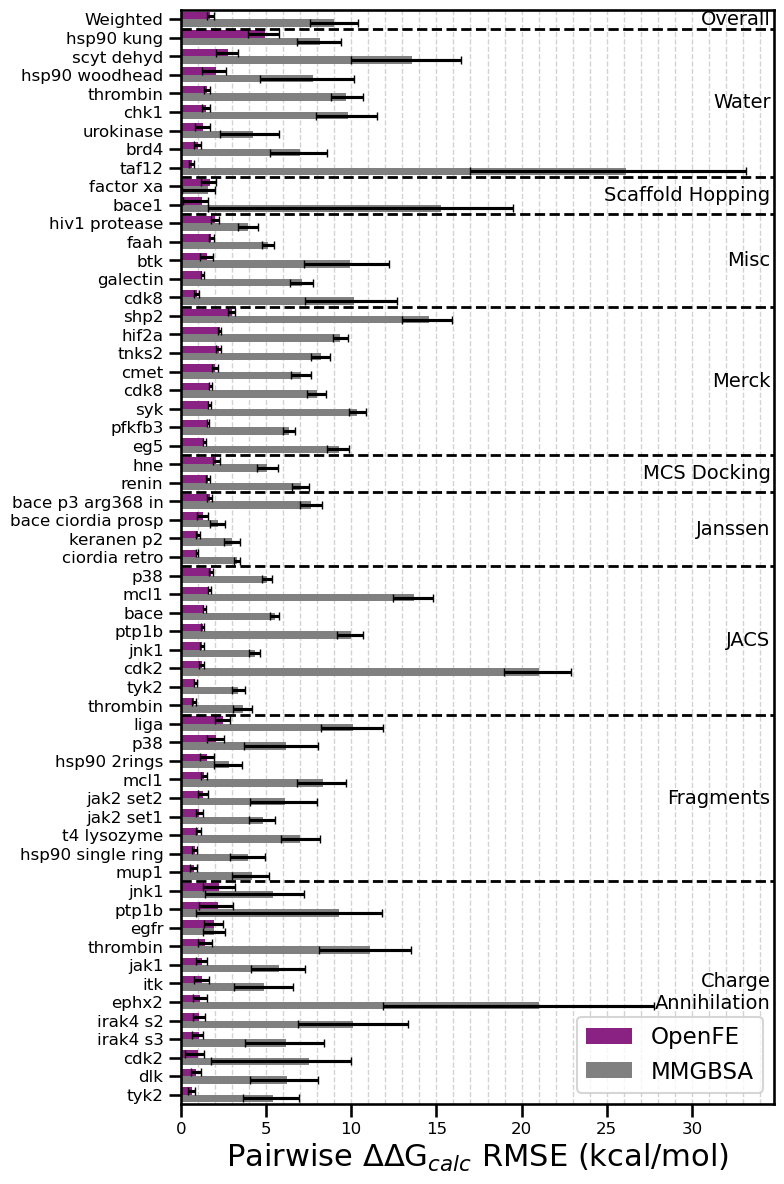

In [149]:
# plot again for OpenFE and MMGBSA for the SI
plot_vertical_rmse_comparison(dg_system_metrics, "OpenFE", "MMGBSA", "pairwise_rmse_comparison_vertical_mmgbsa.png", openfe_color, "gray")

In [36]:
# make a new dataframe with the per system kendall tau values for openfe and FEP+ and plot for the Hahn systems
# must have at least 16 ligands and a range of experimental values of at least 3 kcal/mol
from scipy.stats import kendalltau
kendall_system_metrics = []
for system in dg_data_openfe["system group"].unique():
    # get the edges for these systems
    system_df = dg_data_openfe[dg_data_openfe["system group"] == system].copy(deep=True).reset_index(drop=True)
    targets = system_df["system name"].unique()
    for target in targets:
        # get the edges for this target
        target_df = system_df[(system_df["system name"] == target)].copy(deep=True).reset_index(drop=True)
        if len(target_df) < 16:
            continue
        if abs(target_df["Exp DG (kcal/mol)"].max() - target_df["Exp DG (kcal/mol)"].min()) < 3:
            continue 
        target_data = {"System": target, "Class": system, "N_ligs": len(target_df)}
        tau_openfe, p_value_openfe = kendalltau(target_df["Exp DG (kcal/mol)"], target_df["DG (kcal/mol)"])
        tau_fep_plus, p_value_fep_plus = kendalltau(target_df["Exp DG (kcal/mol)"], target_df["FEP+ DG (kcal/mol)"])
        tau_mmgbsa, p_value_mmgbsa = kendalltau(target_df["Exp DG (kcal/mol)"], target_df["DG MMGBSA"])
        # bootstrap the kendall tau values
        nbootstrap = 1000
        openfe_tau = np.zeros(nbootstrap)
        fep_plus_tau = np.zeros(nbootstrap)
        mmgbsa_tau = np.zeros(nbootstrap)
        for i in range(nbootstrap):
            sample_df = target_df.sample(frac=1, replace=True)
            openfe_tau[i], _ = kendalltau(sample_df["Exp DG (kcal/mol)"], sample_df["DG (kcal/mol)"])
            fep_plus_tau[i], _ = kendalltau(sample_df["Exp DG (kcal/mol)"], sample_df["FEP+ DG (kcal/mol)"])
            mmgbsa_tau[i], _ = kendalltau(sample_df["Exp DG (kcal/mol)"], sample_df["DG MMGBSA"])
        # calculate the mean and CI
        s_openfe = {
            "low": np.percentile(openfe_tau, 2.5),
            "high": np.percentile(openfe_tau, 97.5)
        }
        s_fep_plus = {
            "low": np.percentile(fep_plus_tau, 2.5),
            "high": np.percentile(fep_plus_tau, 97.5)
        }
        s_mmgbsa = {
            "low": np.percentile(mmgbsa_tau, 2.5),
            "high": np.percentile(mmgbsa_tau, 97.5)
        }
        target_data["OpenFE Kendall Tau"] = tau_openfe
        target_data["OpenFE Kendall Tau_lower"] = s_openfe["low"]
        target_data["OpenFE Kendall Tau_upper"] = s_openfe["high"]
        target_data["FEP+ Kendall Tau"] = tau_fep_plus
        target_data["FEP+ Kendall Tau_lower"] = s_fep_plus["low"]
        target_data["FEP+ Kendall Tau_upper"] = s_fep_plus["high"]
        target_data["MMGBSA Kendall Tau"] = tau_mmgbsa
        target_data["MMGBSA Kendall Tau_lower"] = s_mmgbsa["low"]
        target_data["MMGBSA Kendall Tau_upper"] = s_mmgbsa["high"]
        # add the data to a new dataframe
        kendall_system_metrics.append(target_data)
kendall_system_metrics = pd.DataFrame(kendall_system_metrics)
kendall_system_metrics.sort_values(by=['Class', 'OpenFE Kendall Tau'], inplace=True)
kendall_system_metrics

,System,Class,N_ligs,OpenFE Kendall Tau,OpenFE Kendall Tau_lower,OpenFE Kendall Tau_upper,FEP+ Kendall Tau,FEP+ Kendall Tau_lower,FEP+ Kendall Tau_upper,MMGBSA Kendall Tau,MMGBSA Kendall Tau_lower,MMGBSA Kendall Tau_upper
4,p38,jacs_set,34,0.314191,0.087906,0.538604,0.542688,0.351236,0.703558,0.360040,0.141828,0.555760
0,bace,jacs_set,36,0.463268,0.267637,0.630288,0.417605,0.162557,0.628907,-0.086817,-0.338846,0.144031
3,mcl1,jacs_set,42,0.512791,0.332455,0.653215,0.515716,0.314125,0.679424,0.408853,0.264524,0.538689
2,jnk1,jacs_set,21,0.587114,0.358026,0.768844,0.711219,0.528809,0.887797,0.396183,0.148445,0.610426
5,ptp1b,jacs_set,23,0.622786,0.358250,0.824322,0.669351,0.442043,0.813293,0.452014,0.102565,0.740135
1,cdk2,jacs_set,16,0.633333,0.333333,0.877220,0.443519,0.140347,0.750000,-0.466667,-0.682292,-0.135135
6,tyk2,jacs_set,16,0.683333,0.443373,0.880087,0.811723,0.609230,0.963964,0.778249,0.598114,0.929674
7,bace_p3_arg368_in,janssen_bace,21,0.447619,0.183673,0.712979,0.558474,0.290102,0.765823,0.371429,0.075377,0.653465
8,ciordia_retro,janssen_bace,32,0.672049,0.514503,0.802126,0.515673,0.285086,0.690389,0.603240,0.430643,0.755294
9,hne,mcs_docking_set,17,0.538749,0.123036,0.813953,0.450188,0.046510,0.723147,0.405907,0.069604,0.726779


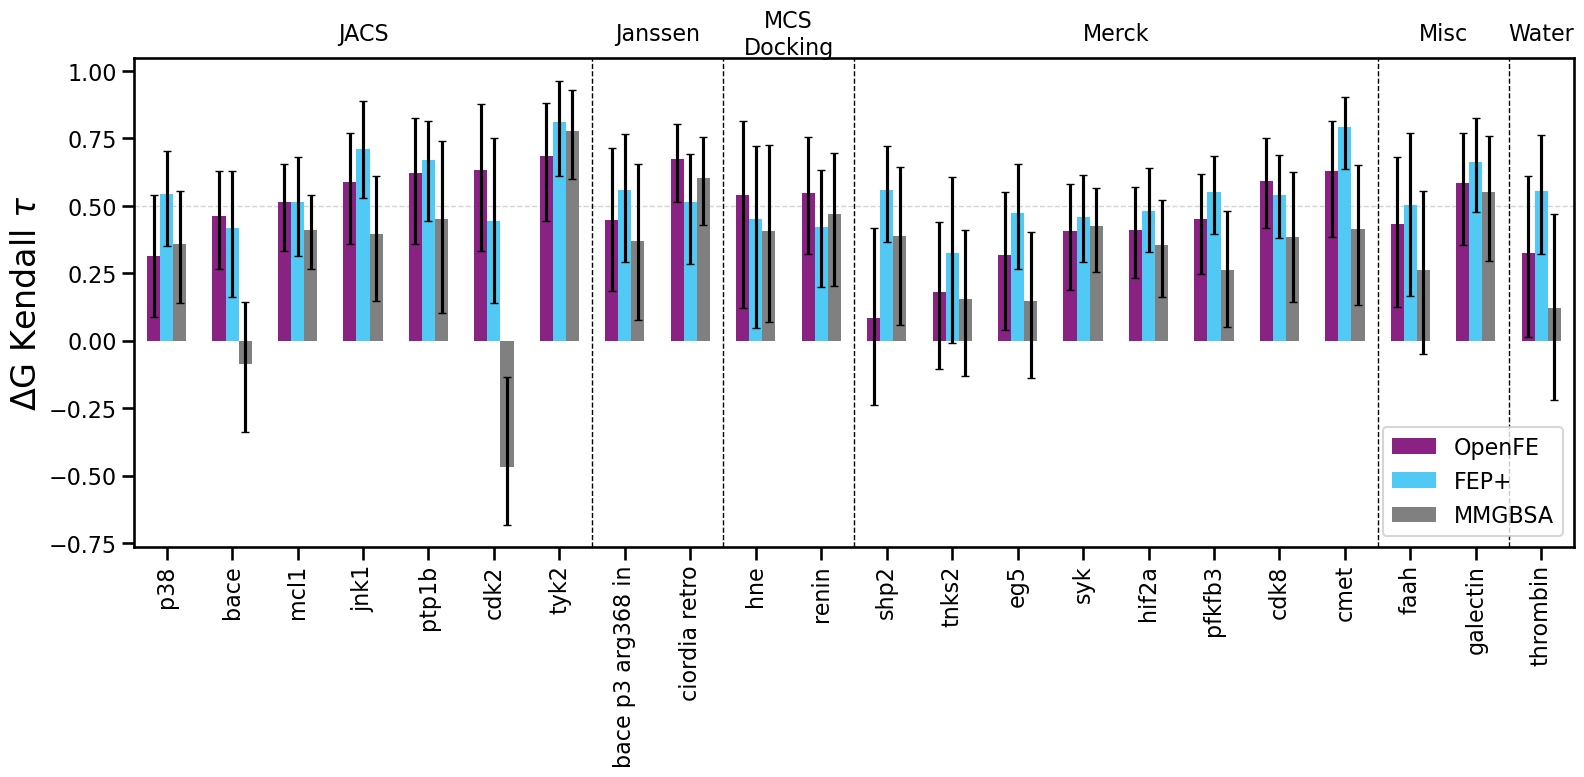

In [157]:
# plot the kendall tau values for OpenFE, FEP+  and MMGBSA with 95% CI for each system
x = np.arange(len(kendall_system_metrics))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.2

# Plot bars with error bars
tau_openfe = [kendall_system_metrics['OpenFE Kendall Tau'] - kendall_system_metrics['OpenFE Kendall Tau_lower'], kendall_system_metrics['OpenFE Kendall Tau_upper'] - kendall_system_metrics['OpenFE Kendall Tau']]
tau_fep_plus = [kendall_system_metrics['FEP+ Kendall Tau'] - kendall_system_metrics['FEP+ Kendall Tau_lower'], kendall_system_metrics['FEP+ Kendall Tau_upper'] - kendall_system_metrics['FEP+ Kendall Tau']]
tau_mmgbsa = [kendall_system_metrics['MMGBSA Kendall Tau'] - kendall_system_metrics['MMGBSA Kendall Tau_lower'], kendall_system_metrics['MMGBSA Kendall Tau_upper'] - kendall_system_metrics['MMGBSA Kendall Tau']]

ax.bar(x - bar_width, kendall_system_metrics['OpenFE Kendall Tau'], yerr=tau_openfe, width=bar_width, label='OpenFE',
       color=openfe_color, capsize=3)
ax.bar(x, kendall_system_metrics['FEP+ Kendall Tau'], yerr=tau_fep_plus, width=bar_width, label='FEP+',
       color=fep_plus_color, capsize=3)
ax.bar(x + bar_width, kendall_system_metrics['MMGBSA Kendall Tau'], yerr=tau_mmgbsa, width=bar_width, label='MMGBSA',
       color='gray', capsize=3)

# Set labels and ticks
ax.set_xticks(x)
names = kendall_system_metrics['System'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=16)
ax.set_ylabel(r"$\Delta$G Kendall $\tau$", fontsize=24)
# make y ticks bigger
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=16)

# Add colored background for classes
unique_classes = kendall_system_metrics['Class'].unique()
# remove overall from the unique classes and add it to the end
class_bounds = kendall_system_metrics.groupby('Class').size().cumsum().to_dict()
class_start = 0

class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls]
    # add dashed lines for collection name
    if cls != "jacs_set":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=1, color="black")

    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.09, cls_name, ha='center', va='center', fontsize=16)
    class_start = end

# add horizontal light grey dashed line at 0.5
ax.axhline(0.5, linestyle='--', color='lightgrey', linewidth=1, zorder=0)

plt.tight_layout()
plt.xlim(-0.5, len(kendall_system_metrics) - 0.5)
plt.savefig("per_system_kendall_tau_openfe_vs_plus.png", dpi=300, bbox_inches='tight')

In [45]:
# calculate the fraction of best ligands metric for each of the hahn systems
# this code is taken from PR <https://github.com/OpenFreeEnergy/cinnabar/pull/122>
import math
def _create_2d_histogram(y_true, y_pred):
    """
    Metric inspired by the talk of Chris Bailey on alchemistry 2024
    Create a 2D histogram from two arrays of data.
    Parameters
    ----------
    y_true : array-like
        The true values.
    y_pred : array-like
        The predicted values.
    Returns
    -------
    histogram : ndarray
        The 2D histogram of the input data.
    bins_true : ndarray
        The bin edges along the y_true axis.
    bins_pred : ndarray
        The bin edges along the y_pred axis.
    Raises
    ------
    ValueError
        If `y_true` and `y_pred` have different lengths.
    TypeError
        If `y_true` or `y_pred` cannot be converted to numpy arrays.
    """
    try:
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
    except Exception as e:
        raise TypeError("Input data cannot be converted to numpy arrays.") from e

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same length.")

    y_true_sorted = np.sort(y_true)
    y_pred_sorted = np.sort(y_pred)

    bins_true = np.concatenate(([y_true.min()], (y_true_sorted[:-1] + y_true_sorted[1:]) / 2, [y_true.max()]))
    bins_pred = np.concatenate(([y_pred.min()], (y_pred_sorted[:-1] + y_pred_sorted[1:]) / 2, [y_pred.max()]))

    histogram, bins_true, bins_pred = np.histogram2d(y_true, y_pred, bins=[bins_true, bins_pred])

    return histogram, bins_true, bins_pred

def _compute_overlap_coefficient(histogram, ranking):
    """
    Compute the overlap coefficient from a 2D histogram.
    The overlap coefficient is calculated based on the counts in the histogram
    for the top N ranked ligands (most active).
    Parameters
    ----------
    histogram : ndarray
        A 2D histogram array where the counts are stored.
    ranking : int
        The number of rankings to consider when computing overlap.
    Returns
    -------
    float
        The overlap coefficient.
    Raises
    ------
    ValueError
        If `top_n_ligands` is greater than the number of ligands in the histogram.
    """
    if ranking < 1:
        raise ValueError("Ranking must be greater than 0.")

    if histogram.shape[0] < ranking:
        raise ValueError("Ranking must be less than the number of ligands.")

    overlap = np.sum(histogram[:ranking, :ranking])

    return overlap / ranking
def compute_fraction_best_ligands(y_true, y_pred, fraction=0.5):
    """
    Compute the fraction of the best ligands metric introduced by Chris Bayly.
    This function calculates the fraction of the best ligands by computing overlap 
    coefficients for each ranking up to the number of ligands and then averaging up to the specified fraction.
    Parameters
    ----------
    y_true : array-like
        The true values.
    y_pred : array-like
        The predicted values.
    fraction : float, optional
        The fraction of ligands to consider as the best (default is 0.5).
    Returns
    -------
    float
        The computed fraction of the best ligands.
    Raises
    ------
    ValueError
        If `fraction` is not between 0 and 1.
    """

    if not (0 <= fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")

    histogram = _create_2d_histogram(y_true, y_pred)[0]
    num_ligands = histogram.shape[0]
    num_best_ligands = math.floor(num_ligands * fraction)

    overlap_coefficients = [_compute_overlap_coefficient(histogram, i + 1) for i in range(num_ligands)]
    best_coefficients = overlap_coefficients[:num_best_ligands]

    fraction_best_ligands = sum(best_coefficients) / num_best_ligands

    return fraction_best_ligands

fraction_best_system_metrics = []
for system in dg_data_openfe["system group"].unique():
    # get the edges for these systems
    system_df = dg_data_openfe[dg_data_openfe["system group"] == system].copy(deep=True).reset_index(drop=True)
    targets = system_df["system name"].unique()
    for target in targets:
        # get the edges for this target
        target_df = system_df[(system_df["system name"] == target)].copy(deep=True).reset_index(drop=True)
        if len(target_df) < 16:
            continue
        if abs(target_df["Exp DG (kcal/mol)"].max() - target_df["Exp DG (kcal/mol)"].min()) < 3:
            continue 
        target_data = {"System": target, "Class": system, "N_ligs": len(target_df)}
        # calculate the fraction of best ligands for OpenFE and FEP+
        target_data["OpenFE Fraction Best"] = compute_fraction_best_ligands(target_df["Exp DG (kcal/mol)"], target_df["DG (kcal/mol)"])
        target_data["FEP+ Fraction Best"] = compute_fraction_best_ligands(target_df["Exp DG (kcal/mol)"], target_df["FEP+ DG (kcal/mol)"])
        target_data["MMGBSA Fraction Best"] = compute_fraction_best_ligands(target_df["Exp DG (kcal/mol)"], target_df["DG MMGBSA"])
        # add the data to a new dataframe
        fraction_best_system_metrics.append(target_data)
fraction_best_system_metrics = pd.DataFrame(fraction_best_system_metrics)
fraction_best_system_metrics.sort_values(by=['Class', 'OpenFE Fraction Best'], inplace=True)
fraction_best_system_metrics


,System,Class,N_ligs,OpenFE Fraction Best,FEP+ Fraction Best,MMGBSA Fraction Best
4,p38,jacs_set,34,0.451312,0.503539,0.410455
3,mcl1,jacs_set,42,0.532683,0.567679,0.349389
6,tyk2,jacs_set,16,0.627976,0.785268,0.597768
2,jnk1,jacs_set,21,0.663056,0.823889,0.512817
0,bace,jacs_set,36,0.709901,0.592218,0.162869
1,cdk2,jacs_set,16,0.718601,0.567560,0.049107
5,ptp1b,jacs_set,23,0.834373,0.816368,0.729604
7,bace_p3_arg368_in,janssen_bace,21,0.556032,0.464643,0.406310
8,ciordia_retro,janssen_bace,32,0.699872,0.648042,0.696101
10,renin,mcs_docking_set,29,0.588890,0.405485,0.540366


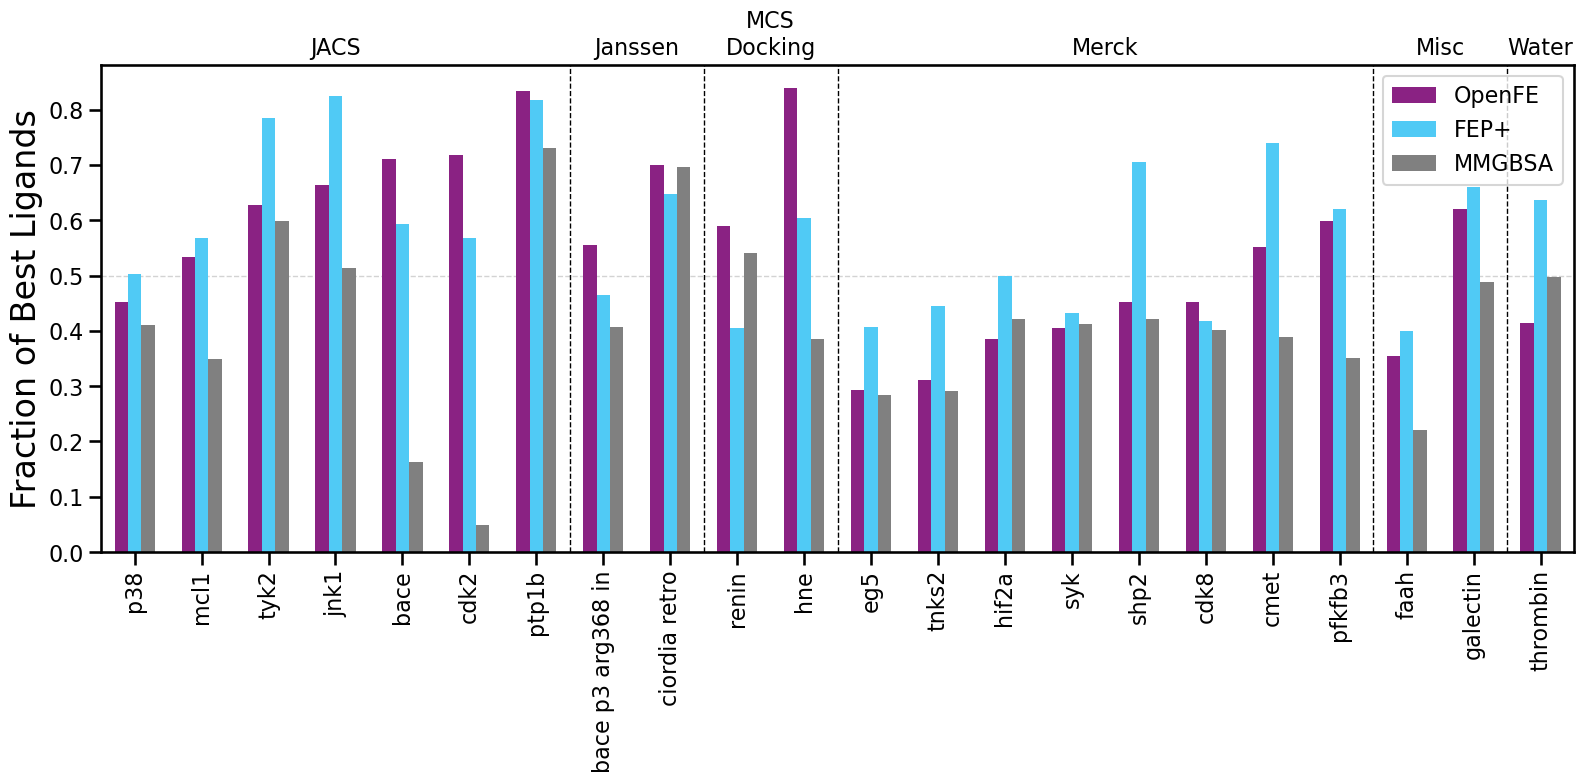

In [159]:
# plot the faction of best ligands for OpenFE and FEP+
x = np.arange(len(fraction_best_system_metrics))
# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.2
# Plot bars 
ax.bar(x - bar_width, fraction_best_system_metrics['OpenFE Fraction Best'], width=bar_width, label='OpenFE',
       color=openfe_color, capsize=3)
ax.bar(x, fraction_best_system_metrics['FEP+ Fraction Best'], width=bar_width, label='FEP+',
       color=fep_plus_color, capsize=3)
ax.bar(x + bar_width, fraction_best_system_metrics['MMGBSA Fraction Best'], width=bar_width, label='MMGBSA',
       color='gray', capsize=3)
# Set labels and ticks
ax.set_xticks(x)
names = fraction_best_system_metrics['System'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=16)
ax.set_ylabel(r"Fraction of Best Ligands", fontsize=24)
ax.legend(fontsize=16)
# make y ticks bigger
ax.tick_params(axis='y', labelsize=16)

# Add dashed line for the class names
unique_classes = fraction_best_system_metrics['Class'].unique()


class_bounds = fraction_best_system_metrics.groupby('Class').size().cumsum().to_dict()
class_start = 0

class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls]
    # add dashed lines for the span but not the fill
    if cls != "jacs_set":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=1, color="black")

    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.01, cls_name, ha='center', va='bottom', fontsize=16)
    class_start = end
# add horizontal light grey dashed line at 0.5
ax.axhline(0.5, linestyle='--', color='lightgrey', linewidth=1, zorder=0)
plt.tight_layout()
plt.xlim(-0.5, len(fraction_best_system_metrics) - 0.5)
plt.savefig("per_system_fraction_best_ligands_openfe_vs_plus.png", dpi=300, bbox_inches='tight')


In [49]:
# make a new dataframe with all possible pairwise DDG values for openfe, fep+ and mmgbsa
all_pairwise_ddgs = []
for system in dg_data_openfe["system group"].unique():
    # get the edges for these systems
    system_df = dg_data_openfe[dg_data_openfe["system group"] == system].copy(deep=True).reset_index(drop=True)
    targets = system_df["system name"].unique()
    for target in targets:
        # get the edges for this target
        target_df = system_df[(system_df["system name"] == target)].copy(deep=True).reset_index(drop=True)
        # get the ligands
        ligands = target_df["ligand name"].unique()
        for i, ligand1 in enumerate(ligands):
            for j, ligand2 in enumerate(ligands):
                if i >= j:  # skip self-comparisons
                    continue
                # get the ddg values for these ligands
                exp_dg1 = target_df[target_df["ligand name"] == ligand1]["Exp DG (kcal/mol)"].values[0]
                exp_dg2 = target_df[target_df["ligand name"] == ligand2]["Exp DG (kcal/mol)"].values[0]
                openfe_dg1 = target_df[target_df["ligand name"] == ligand1]["DG (kcal/mol)"].values[0]
                openfe_dg2 = target_df[target_df["ligand name"] == ligand2]["DG (kcal/mol)"].values[0]
                fep_plus_dg1 = target_df[target_df["ligand name"] == ligand1]["FEP+ DG (kcal/mol)"].values[0]
                fep_plus_dg2 = target_df[target_df["ligand name"] == ligand2]["FEP+ DG (kcal/mol)"].values[0]
                mmgbsa_dg1 = target_df[target_df["ligand name"] == ligand1]["DG MMGBSA"].values[0]
                mmgbsa_dg2 = target_df[target_df["ligand name"] == ligand2]["DG MMGBSA"].values[0]
                # add to a new dataframe
                new_row = {
                    "System": target,
                    "Class": system,
                    "Ligand 1": ligand1,
                    "Ligand 2": ligand2,
                    "Exp DDG (kcal/mol)": exp_dg2 - exp_dg1,
                    "OpenFE DDG (kcal/mol)": openfe_dg2 - openfe_dg1,
                    "FEP+ DDG (kcal/mol)": fep_plus_dg2 - fep_plus_dg1,
                    "MMGBSA DDG (kcal/mol)": mmgbsa_dg2 - mmgbsa_dg1,
                }
                all_pairwise_ddgs.append(new_row)
all_pairwise_ddgs = pd.DataFrame(all_pairwise_ddgs)
all_pairwise_ddgs

,System,Class,Ligand 1,Ligand 2,Exp DDG (kcal/mol),OpenFE DDG (kcal/mol),FEP+ DDG (kcal/mol),MMGBSA DDG (kcal/mol)
0,cdk2,charge_annihilation_set,25,34,-0.050000,-0.304872,-0.459999,-1.8
1,cdk2,charge_annihilation_set,25,39charg,1.460000,2.570102,1.540001,9.7
2,cdk2,charge_annihilation_set,34,39charg,1.510000,2.874974,2.000000,11.5
3,dlk,charge_annihilation_set,17charg,18,0.460000,-0.090194,0.650000,5.1
4,dlk,charge_annihilation_set,17charg,4charg,1.110000,1.675808,1.750000,6.1
...,...,...,...,...,...,...,...,...
10127,urokinase,water_set,"10302 (1GJ7, no water pose)",7806 (no water pose),2.170857,3.103786,2.080000,8.8
10128,urokinase,water_set,"10302 (1GJ7, no water pose)",8696 (no water pose),1.020183,3.057647,1.250000,6.8
10129,urokinase,water_set,11417 (no water pose),7806 (no water pose),1.914111,0.996598,1.090000,3.3
10130,urokinase,water_set,11417 (no water pose),8696 (no water pose),0.763436,0.950458,0.260000,1.3


Probability of OpenFE being below 1 kcal/mol: 47.36%
Probability of FEP+ being below 1 kcal/mol: 60.69%
Probability of OpenFE being below 2 kcal/mol: 78%
Probability of FEP+ being below 2 kcal/mol: 90%


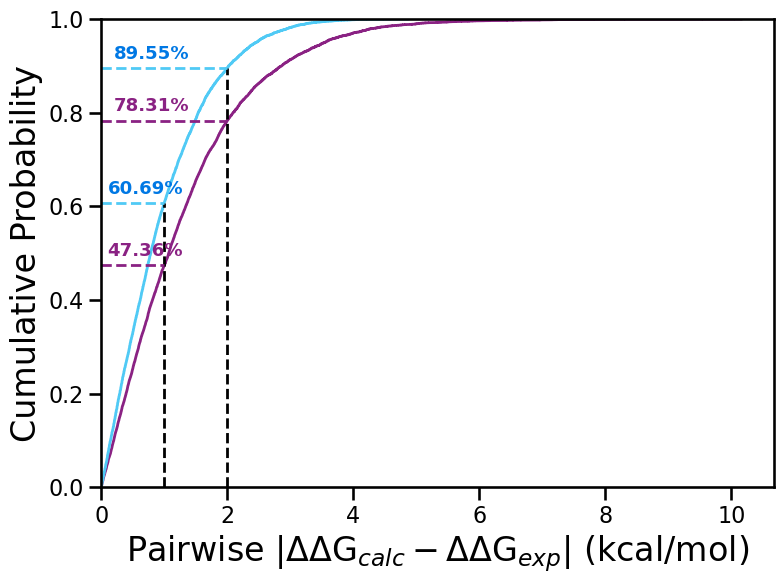

In [166]:
# plot ecdfs for openfe and fep+ ddg absolute errors
fig, ax = plt.subplots(figsize=(8, 6))

openfe_abs_ddg = np.abs(all_pairwise_ddgs["OpenFE DDG (kcal/mol)"] - all_pairwise_ddgs["Exp DDG (kcal/mol)"])
fep_plus_abs_ddg = np.abs(all_pairwise_ddgs["FEP+ DDG (kcal/mol)"] - all_pairwise_ddgs["Exp DDG (kcal/mol)"])

sns.ecdfplot(data=openfe_abs_ddg, ax=ax, label="OpenFE", color=openfe_color, linewidth=2)
sns.ecdfplot(data=fep_plus_abs_ddg, ax=ax, label="FEP+", color=fep_plus_color, linewidth=2)
# calculate the probability of being below 1 kcal/mol for both
prob_below_1_openfe = np.sum(openfe_abs_ddg < 1) / len(openfe_abs_ddg)
prob_below_1_fep_plus = np.sum(fep_plus_abs_ddg < 1) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 1 kcal/mol: {prob_below_1_openfe:.2%}")
print(f"Probability of FEP+ being below 1 kcal/mol: {prob_below_1_fep_plus:.2%}")
# add a line at 1 kcal/mol for both
ax.axvline(x=1, ymax=prob_below_1_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_openfe, prob_below_1_openfe], color=openfe_color, linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_fep_plus, prob_below_1_fep_plus], color=fep_plus_color, linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.1, prob_below_1_openfe + 0.02, f"{prob_below_1_openfe:.2%}", color=openfe_color, fontsize=13, weight='bold')
ax.text(0.1, prob_below_1_fep_plus + 0.02, f"{prob_below_1_fep_plus:.2%}", color="#0078E4", fontsize=13, weight='bold')
# same again for 2  kcal/mol
prob_below_2_openfe = np.sum(openfe_abs_ddg < 2) / len(openfe_abs_ddg)
prob_below_2_fep_plus = np.sum(fep_plus_abs_ddg < 2) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 2 kcal/mol: {prob_below_2_openfe:.0%}")
print(f"Probability of FEP+ being below 2 kcal/mol: {prob_below_2_fep_plus:.0%}")
# stop the line at the higher probability curve 

ax.axvline(x=2, ymax=prob_below_2_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_openfe, prob_below_2_openfe], color=openfe_color, linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_fep_plus, prob_below_2_fep_plus], color=fep_plus_color, linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.2, prob_below_2_openfe + 0.02, f"{prob_below_2_openfe:.2%}", color=openfe_color, fontsize=13, weight='bold')
ax.text(0.2, prob_below_2_fep_plus + 0.02, f"{prob_below_2_fep_plus:.2%}", color="#0078E4", fontsize=13, weight='bold')

# set the x and y labels
ax.set_xlabel(r"Pairwise $|\Delta\Delta$G$_{calc}-\Delta\Delta$G$_{exp}|$ (kcal/mol)", fontsize=24)
ax.set_ylabel("Cumulative Probability", fontsize=24)
# set x and y tick font size
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlim(left=0)
# remove the top and right spines
# sns.despine()
# plt.legend(fontsize=16)
plt.tight_layout()
# save the figure
plt.savefig("ecdf_pairwise_abs_ddg_error_opnfe_vs_fep_plus.png", dpi=300, bbox_inches='tight')

Probability of OpenFE being below 1 kcal/mol: 47.36%
Probability of MMGBSA being below 1 kcal/mol: 12.87%
Probability of OpenFE being below 2 kcal/mol: 78%
Probability of MMGBSA being below 2 kcal/mol: 24%


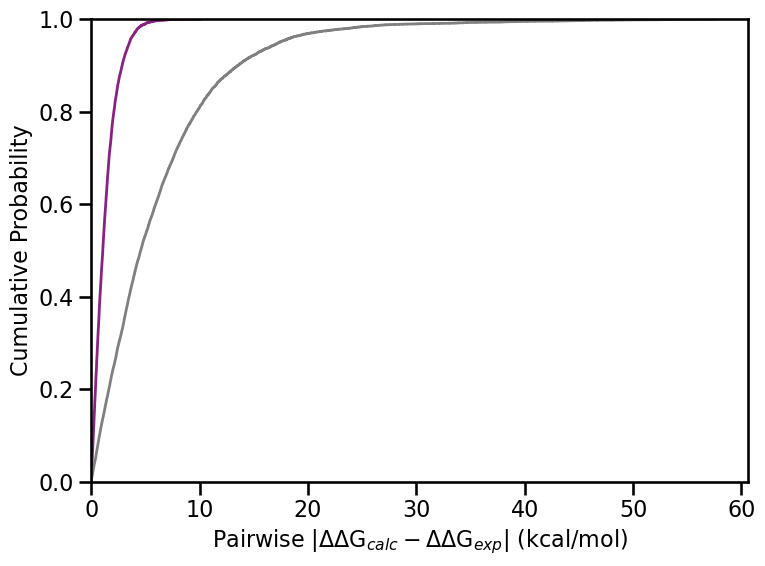

In [54]:
# plot again to compare OpenFE and MMGBSA for the SI
# plot ecdfs for openfe and fep+ ddg absolute errors
fig, ax = plt.subplots(figsize=(8, 6))

openfe_abs_ddg = np.abs(all_pairwise_ddgs["OpenFE DDG (kcal/mol)"] - all_pairwise_ddgs["Exp DDG (kcal/mol)"])
mmgbsa_abs_ddg = np.abs(all_pairwise_ddgs["MMGBSA DDG (kcal/mol)"] - all_pairwise_ddgs["Exp DDG (kcal/mol)"])

sns.ecdfplot(data=openfe_abs_ddg, ax=ax, label="OpenFE", color=openfe_color, linewidth=2)
sns.ecdfplot(data=mmgbsa_abs_ddg, ax=ax, label="MMGBSA", color='gray', linewidth=2)
# calculate the probability of being below 1 kcal/mol for both
prob_below_1_openfe = np.sum(openfe_abs_ddg < 1) / len(openfe_abs_ddg)
prob_below_1_mmgbsa = np.sum(mmgbsa_abs_ddg < 1) / len(mmgbsa_abs_ddg)
print(f"Probability of OpenFE being below 1 kcal/mol: {prob_below_1_openfe:.2%}")
print(f"Probability of MMGBSA being below 1 kcal/mol: {prob_below_1_mmgbsa:.2%}")
# add a line at 1 kcal/mol for both
# ax.axvline(x=1, ymax=prob_below_1_openfe, color='k', linestyle='--', linewidth=2)
# ax.plot([0, 1], [prob_below_1_openfe, prob_below_1_openfe], color=openfe_color, linestyle='--', linewidth=2)
# ax.plot([0, 1], [prob_below_1_mmgbsa, prob_below_1_mmgbsa], color='gray', linestyle='--', linewidth=2)
# add a label above the line
# ax.text(0.1, prob_below_1_openfe + 0.02, f"{prob_below_1_openfe:.2%}", color=openfe_color, fontsize=13)
# ax.text(1, prob_below_1_mmgbsa + 0.02, f"{prob_below_1_mmgbsa:.2%}", color='gray', fontsize=13)
# same again for 2  kcal/mol
prob_below_2_openfe = np.sum(openfe_abs_ddg < 2) / len(openfe_abs_ddg)
prob_below_2_mmgbsa = np.sum(mmgbsa_abs_ddg < 2) / len(mmgbsa_abs_ddg)
print(f"Probability of OpenFE being below 2 kcal/mol: {prob_below_2_openfe:.0%}")
print(f"Probability of MMGBSA being below 2 kcal/mol: {prob_below_2_mmgbsa:.0%}")
# stop the line at the higher probability curve 

# ax.axvline(x=2, ymax=prob_below_2_openfe, color='k', linestyle='--', linewidth=2)
# ax.plot([0, 2], [prob_below_2_openfe, prob_below_2_openfe], color=openfe_color, linestyle='--', linewidth=2)
# ax.plot([0, 2], [prob_below_2_mmgbsa, prob_below_2_mmgbsa], color='gray', linestyle='--', linewidth=2)
# add a label above the line
# ax.text(0.2, prob_below_2_openfe + 0.02, f"{prob_below_2_openfe:.2%}", color=openfe_color, fontsize=13)
# ax.text(0.2, prob_below_2_mmgbsa + 0.02, f"{prob_below_2_mmgbsa:.2%}", color='gray', fontsize=13)

# set the x and y labels
ax.set_xlabel(r"Pairwise $|\Delta\Delta$G$_{calc}-\Delta\Delta$G$_{exp}|$ (kcal/mol)", fontdict={"fontsize": 16})
ax.set_ylabel("Cumulative Probability", fontdict={"fontsize": 16})
# set x and y tick font size
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlim(left=0)
# remove the top and right spines
# sns.despine()
# plt.legend(fontsize=16)
plt.tight_layout()
# save the figure
plt.savefig("ecdf_pairwise_abs_ddg_error_openfe_vs_mmgbsa.png", dpi=300, bbox_inches='tight')

In [55]:
# bin the absolute experimental DDG values in 0.5 kcal/mol bins 
# calculate the probability of gettting the sign of the DDG correct with openfe and fep+ for each bin
def bin_sign_correctness(data, bin_size=0.5):
    # get the absolute experimental DDG values
    data['abs_exp_ddg'] = np.abs(data['Exp DDG (kcal/mol)'])
    # max value value to work out the bins
    max_value = data['abs_exp_ddg'].max()
    bins = np.arange(0, max_value + bin_size, bin_size)
    
    # Bin the data
    data['bin'] = pd.cut(data['abs_exp_ddg'], bins=bins, right=False)
    
    # Calculate probabilities
    results = []
    # sort the bins by the lower edge
    for b in sorted(data['bin'].unique(), key=lambda x: x.left):
        subset = data[data['bin'] == b]
        if len(subset) == 0:
            continue
        # Calculate the probability of correct sign for OpenFE and FEP+ and bootstrap the results
        openfe_correct = np.sum(np.sign(subset['OpenFE DDG (kcal/mol)']) == np.sign(subset['Exp DDG (kcal/mol)']))
        fep_plus_correct = np.sum(np.sign(subset['FEP+ DDG (kcal/mol)']) == np.sign(subset['Exp DDG (kcal/mol)']))
        mmgbsa_correct = np.sum(np.sign(subset['MMGBSA DDG (kcal/mol)']) == np.sign(subset['Exp DDG (kcal/mol)']))
        total = len(subset)
        # Bootstrap the probabilities
        nboots = 1000
        openfe_probs = []
        fep_plus_probs = [] 
        mmgbsa_probs = []
        for _ in range(nboots):
            bootstrapped_subset = subset.sample(n=len(subset), replace=True)
            openfe_correct_boot = np.sum(np.sign(bootstrapped_subset['OpenFE DDG (kcal/mol)']) == np.sign(bootstrapped_subset['Exp DDG (kcal/mol)']))
            fep_plus_correct_boot = np.sum(np.sign(bootstrapped_subset['FEP+ DDG (kcal/mol)']) == np.sign(bootstrapped_subset['Exp DDG (kcal/mol)']))
            mmgbsa_correct_boot = np.sum(np.sign(bootstrapped_subset['MMGBSA DDG (kcal/mol)']) == np.sign(bootstrapped_subset['Exp DDG (kcal/mol)']))
            total_boot = len(bootstrapped_subset)
            openfe_probs.append(openfe_correct_boot / total_boot)
            fep_plus_probs.append(fep_plus_correct_boot / total_boot)
            mmgbsa_probs.append(mmgbsa_correct_boot / total_boot)
        # Calculate mean and 95% CI
        openfe_sample = openfe_correct / total
        fep_plus_sample = fep_plus_correct / total
        mmgbsa_sample = mmgbsa_correct / total
        openfe_low = np.percentile(openfe_probs, 2.5)
        openfe_high = np.percentile(openfe_probs, 97.5)
        fep_plus_low = np.percentile(fep_plus_probs, 2.5)
        fep_plus_high = np.percentile(fep_plus_probs, 97.5)
        mmgbsa_low = np.percentile(mmgbsa_probs, 2.5)
        mmgbsa_high = np.percentile(mmgbsa_probs, 97.5)
        # store the results so we can use hue to split the data
        results.append({
            'bin': b.left,
            'bin_size': total,
            'OpenFE Probability': openfe_sample,
            'OpenFE Probability Lower': openfe_low,
            'OpenFE Probability Upper': openfe_high,
            'FEP+ Probability': fep_plus_sample,
            'FEP+ Probability Lower': fep_plus_low,
            'FEP+ Probability Upper': fep_plus_high,
            'MMGBSA Probability': mmgbsa_sample,
            'MMGBSA Probability Lower': mmgbsa_low,
            'MMGBSA Probability Upper': mmgbsa_high,
        })
        # x+=1
    return pd.DataFrame(results)
# Calculate the binned probabilities
binned_probabilities = bin_sign_correctness(all_pairwise_ddgs, bin_size=0.5)

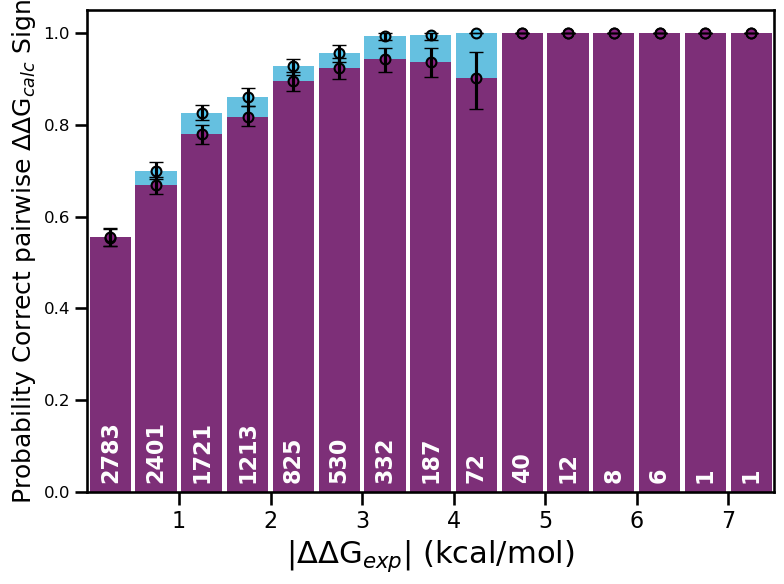

In [146]:

# Plot the binned probabilities using a bar plot with error bars
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=binned_probabilities, x='bin', y='FEP+ Probability', ax=ax, color=fep_plus_color, width=0.9)
sns.barplot(data=binned_probabilities, x='bin', y='OpenFE Probability', ax=ax, color=openfe_color, width=0.9)
# add error bars for the probabilities
ax.set_xlabel(r"|$\Delta\Delta$G$_{exp}$| (kcal/mol)", fontsize=22)
ax.set_ylabel(r"Probability Correct pairwise $\Delta\Delta$G$_{calc}$ Sign", fontsize=18)
# set the x ticks to go from 0 to the max bin value in 1 kcal/mol increments
x_ticks = np.arange(1.5, 15.5, 2)
ax.errorbar(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'],
            yerr=[binned_probabilities['OpenFE Probability'] - binned_probabilities['OpenFE Probability Lower'],
                  binned_probabilities['OpenFE Probability Upper'] - binned_probabilities['OpenFE Probability']],
            fmt='none', color='black', capsize=5)
ax.errorbar(binned_probabilities['bin'] *2, binned_probabilities['FEP+ Probability'],
            yerr=[binned_probabilities['FEP+ Probability'] - binned_probabilities['FEP+ Probability Lower'],
                  binned_probabilities['FEP+ Probability Upper'] - binned_probabilities['FEP+ Probability']],
            fmt='none', color='black', capsize=5)
# add scatter points for the probabilities
ax.scatter(binned_probabilities['bin'] *2, binned_probabilities['FEP+ Probability'], color=fep_plus_color, edgecolor='black', s=50)
ax.scatter(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'], color=openfe_color, edgecolor='black', s=50)
# add the number of pairs in each bin at the base of each bar
for i, row in binned_probabilities.iterrows():
      if not np.isnan(row['OpenFE Probability']):
            ax.text(row['bin'] * 2, 0.02, str(int(row['bin_size'])), ha='center', va='bottom', fontsize=16, color='white', weight='bold', rotation=90)
# print(x_ticks)
# print(ax.get_xticks())
ax.set_xticks(x_ticks)
ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7], fontsize=16)
plt.xlim((-0.5,14.5))
# save the figure
# plt.legend(fontsize=12)

plt.ylim()
plt.tight_layout()
plt.savefig("binned_sign_correctness_openfe_vs_fep_plus.png", dpi=300, bbox_inches='tight')

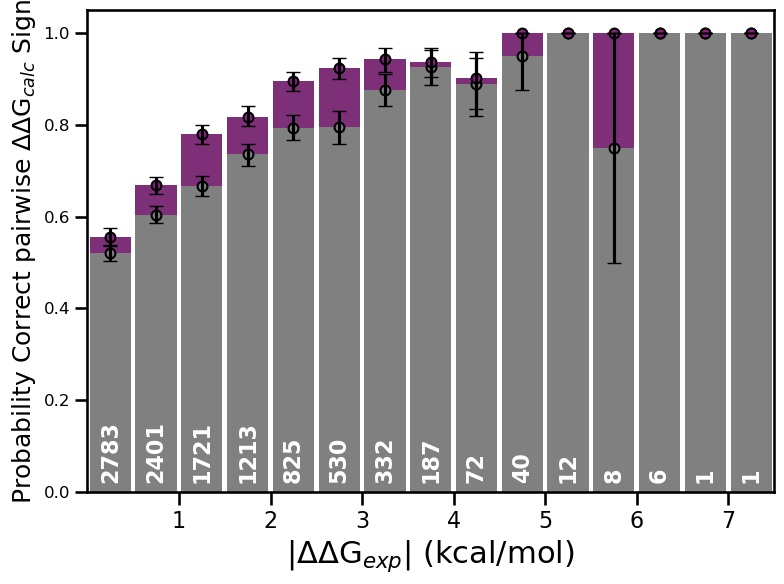

In [163]:
# plot again with mmgbsa for the SI

# Plot the binned probabilities using a bar plot with error bars
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=binned_probabilities, x='bin', y='OpenFE Probability', ax=ax, color=openfe_color, width=0.9)
sns.barplot(data=binned_probabilities, x='bin', y='MMGBSA Probability', ax=ax, color="grey", width=0.9)
# add error bars for the probabilities
ax.set_xlabel(r"|$\Delta\Delta$G$_{exp}$| (kcal/mol)", fontsize=22)
ax.set_ylabel(r"Probability Correct pairwise $\Delta\Delta$G$_{calc}$ Sign", fontsize=18)
# set the x ticks to go from 0 to the max bin value in 1 kcal/mol increments
x_ticks = np.arange(1.5, 15.5, 2)
ax.errorbar(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'],
            yerr=[binned_probabilities['OpenFE Probability'] - binned_probabilities['OpenFE Probability Lower'],
                  binned_probabilities['OpenFE Probability Upper'] - binned_probabilities['OpenFE Probability']],
            fmt='none', color='black', capsize=5)
ax.errorbar(binned_probabilities['bin'] *2, binned_probabilities['MMGBSA Probability'],
            yerr=[binned_probabilities['MMGBSA Probability'] - binned_probabilities['MMGBSA Probability Lower'],
                  binned_probabilities['MMGBSA Probability Upper'] - binned_probabilities['MMGBSA Probability']],
            fmt='none', color='black', capsize=5)
# add scatter points for the probabilities
ax.scatter(binned_probabilities['bin'] *2, binned_probabilities['MMGBSA Probability'], color="grey", edgecolor='black', s=50)
ax.scatter(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'], color=openfe_color, edgecolor='black', s=50)
# add the number of pairs in each bin at the base of each bar
for i, row in binned_probabilities.iterrows():
      if not np.isnan(row['OpenFE Probability']):
            ax.text(row['bin'] * 2, 0.02, str(int(row['bin_size'])), ha='center', va='bottom', fontsize=16, color='white', weight='bold', rotation=90)
# print(x_ticks)
# print(ax.get_xticks())
ax.set_xticks(x_ticks)
ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7], fontsize=16)
plt.xlim((-0.5,14.5))
# save the figure
# plt.legend(fontsize=12)

plt.ylim()
plt.tight_layout()
plt.savefig("binned_sign_correctness_openfe_vs_mmgbsa.png", dpi=300, bbox_inches='tight')

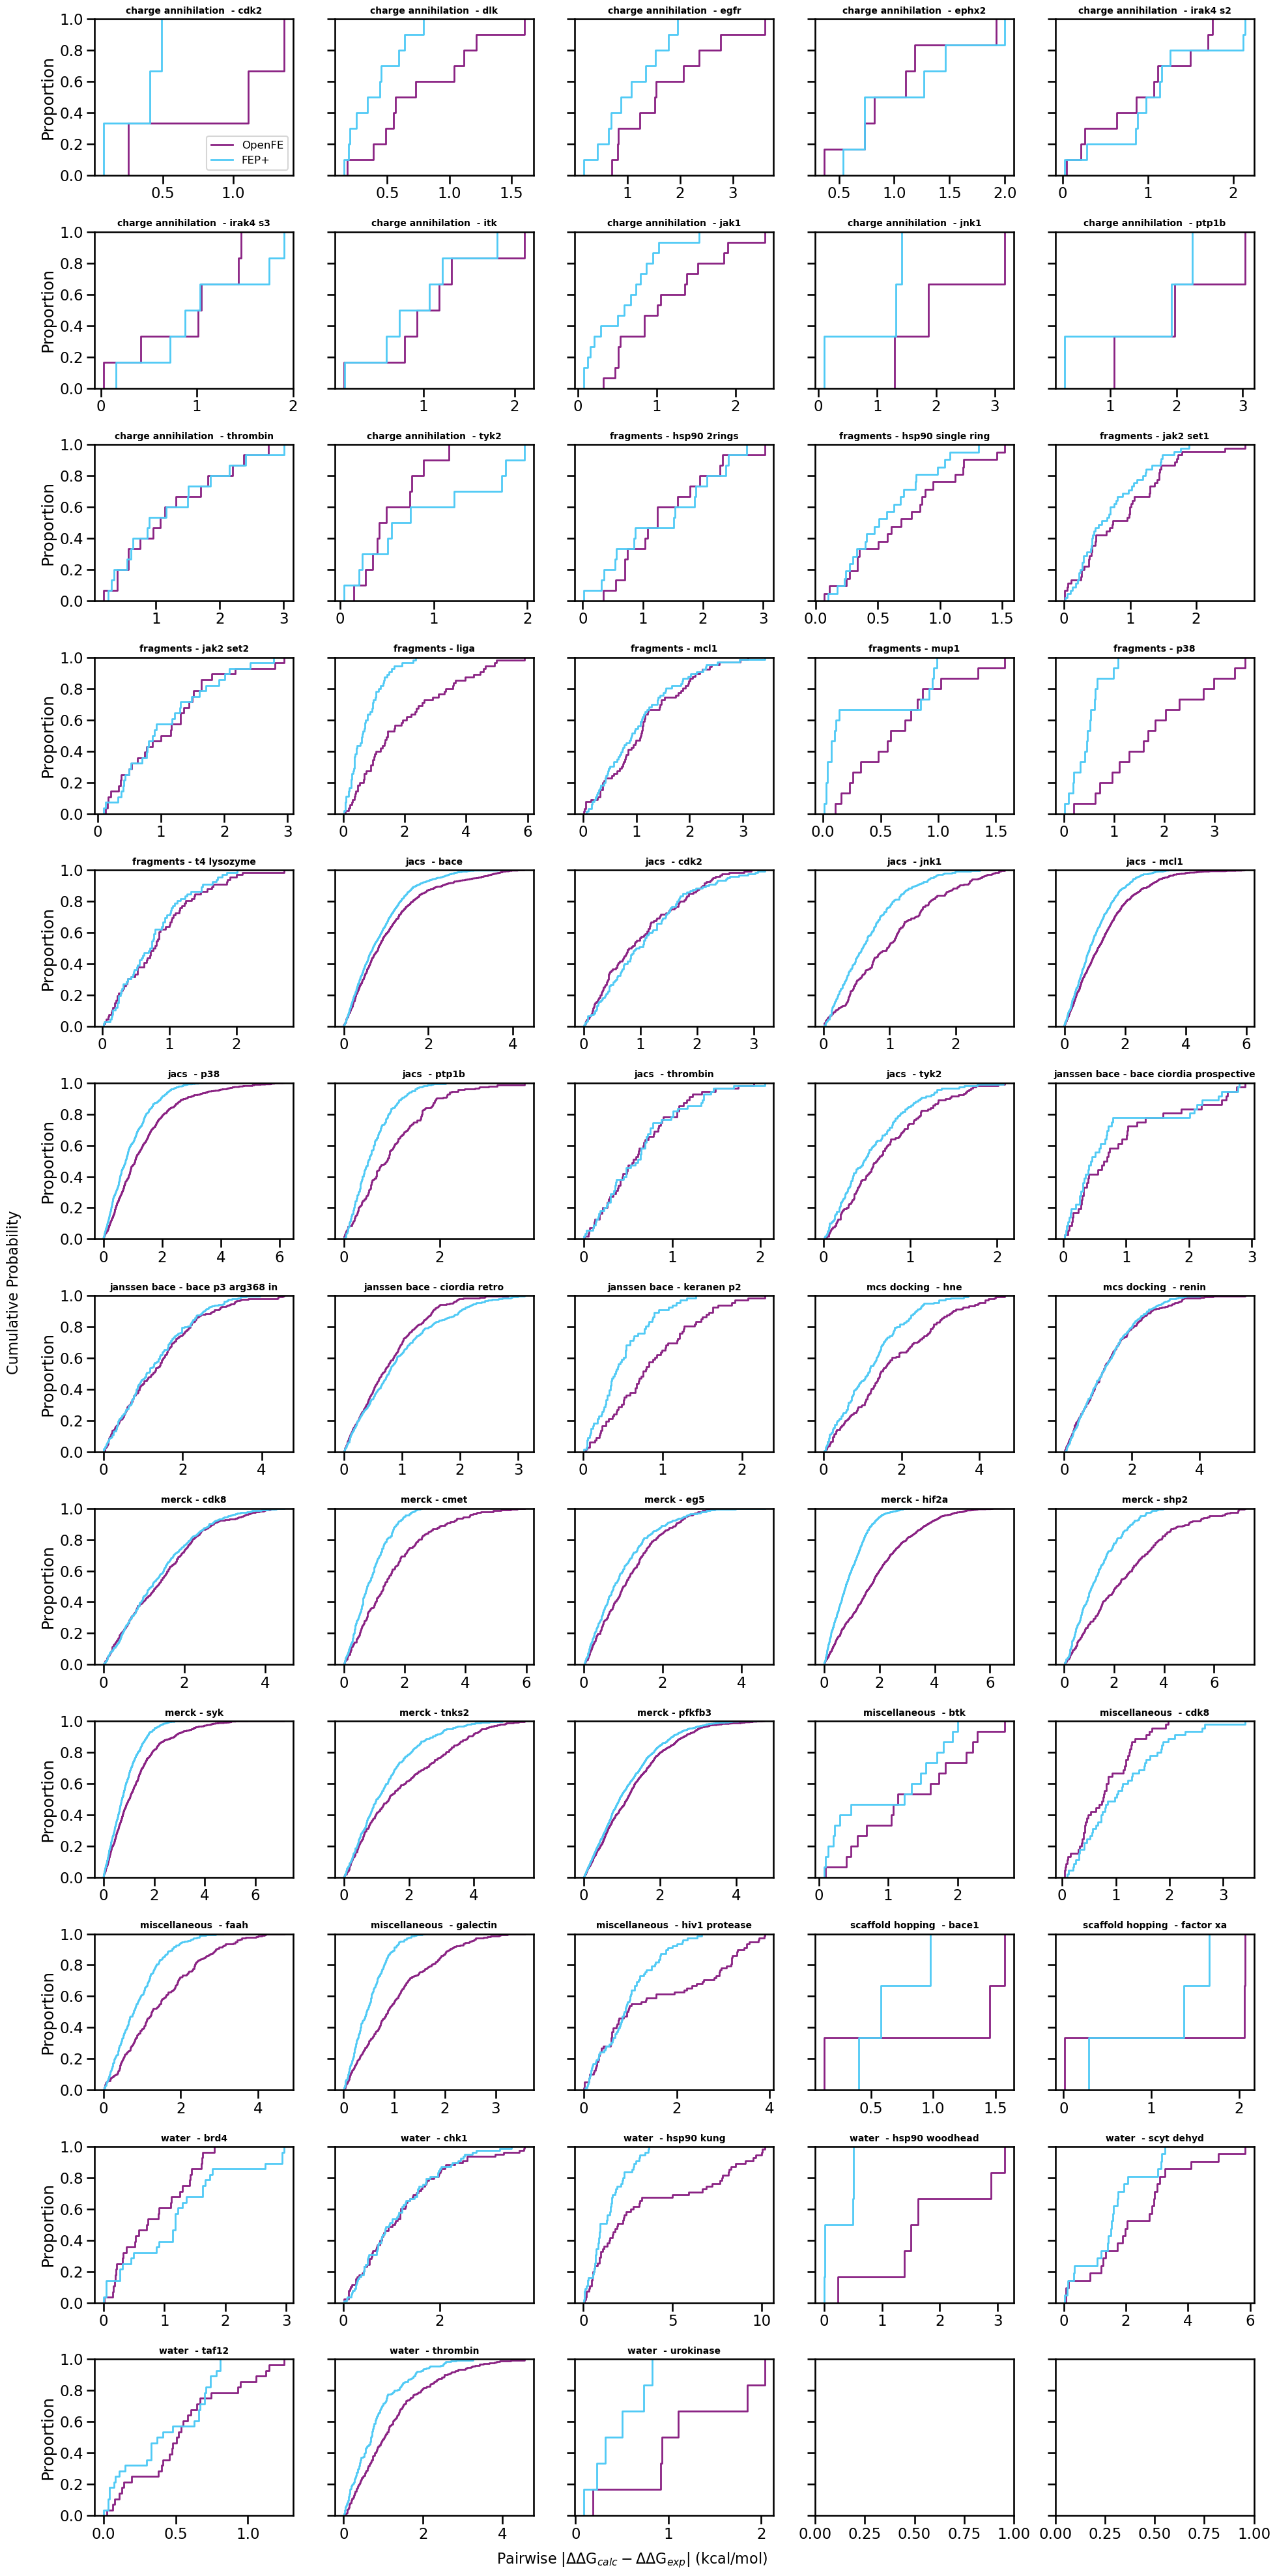

: 

In [ ]:
# make a 12x5 grid of subplots with shared y axis and compare the openfe and fep absolute errors using ecdfs for each system name
fig, axs = plt.subplots(12, 5, figsize=(20, 40), sharey=True)
# reduce the space between the subplots
plt.subplots_adjust(hspace=0.2, wspace=0.2)
# Flatten the axes array for easier iteration
axs = axs.flatten()
i=0
# Loop through each system and plot the data  
system_groups = all_pairwise_ddgs["Class"].unique()
for system in system_groups:
    system_df = all_pairwise_ddgs[all_pairwise_ddgs["Class"] == system].copy(deep=True).reset_index(drop=True)
    # get the unique target names
    target_names = system_df["System"].unique()    
    for target in target_names:
        # get the edges for this target
        target_df = system_df[system_df["System"] == target].copy(deep=True).reset_index(drop=True)
        # calculate the absolute errors
        openfe_abs_ddg = np.abs(target_df["OpenFE DDG (kcal/mol)"] - target_df["Exp DDG (kcal/mol)"])
        fep_plus_abs_ddg = np.abs(target_df["FEP+ DDG (kcal/mol)"] - target_df["Exp DDG (kcal/mol)"])
        # plot the ecdf
        sns.ecdfplot(data=openfe_abs_ddg, ax=axs[i], label="OpenFE", color=openfe_color, linewidth=2)
        sns.ecdfplot(data=fep_plus_abs_ddg, ax=axs[i], label="FEP+", color=fep_plus_color, linewidth=2)
        axs[i].set_title(f"{system.replace('_', ' ').replace('set','')} - {target.replace('_', ' ')}", fontsize=10, fontweight='bold')
        i+= 1
# Set the y-label for all subplots
fig.supylabel("Cumulative Probability", fontsize=16)
# Set the x-label for all subplots
fig.supxlabel(r"Pairwise $|\Delta\Delta$G$_{calc}-\Delta\Delta$G$_{exp}|$ (kcal/mol)", fontsize=16)
# add the legend to the first subplot
axs[0].legend(prop={"size": 12})
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("ecdf_pairwise_abs_ddg_error_opnfe_vs_fep_plus_per_system.png", dpi=300, bbox_inches='tight')


In [58]:
# get the overlapping edges between openfe and fep+
# we need to check for reverse edges as well
overlaping_edges = []
for _, row in all_openfe_edges.iterrows():
    data = row.to_dict()
    # find the row in the FEP+ data
    fep_group = fep_plus_edge_data[(fep_plus_edge_data["system group"] == row["system group"]) & (fep_plus_edge_data["system name"] == row["system name"])]
    # try the forward ligands
    fep_data_row = fep_group[(fep_group["Lig 1"] == row["ligand_A"]) & (fep_group["Lig 2"] == row["ligand_B"])]
    backwards = False
    if len(fep_data_row) == 0:
        # try the reverse
        fep_data_row = fep_group[(fep_group["Lig 2"] == row["ligand_A"]) & (fep_group["Lig 1"] == row["ligand_B"])]
        backwards = True
    if len(fep_data_row) == 1:
        factor = -1 if backwards else 1
        fep_data = fep_data_row.iloc[0]
        data["FEP+ Bennett ddG (kcal/mol)"] = fep_data["Bennett ddG (kcal/mol)"] * factor
        data["FEP+ Bennett std. error (kcal/mol)"] = fep_data["Bennett std. error (kcal/mol)"]
        data["FEP+ CCC ddG (kcal/mol)"] = fep_data["CCC ddG (kcal/mol)"] * factor
        data["FEP+ CCC std. error (kcal/mol)"] = fep_data["CCC std. error (kcal/mol)"]
        # check the the experimental ddg values are the same after the conversion factor
        assert round(row["exp DDG (kcal/mol)"], ndigits=4)  == round(factor * fep_data["Exp. ddG (kcal/mol)"], ndigits=4), print(round(factor * fep_data["Exp. ddG (kcal/mol)"], ndigits=4), round(row["exp DDG (kcal/mol)"], ndigits=4))
        overlaping_edges.append(data)

overlap_df = pd.DataFrame(overlaping_edges)
overlap_df



,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_smallest_overlap,failed,system group,system name,DDG_bind (kcal/mol),stdev DDG_bind (kcal/mol),FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,0.111000,NaN,charge_annihilation_set,cdk2,0.456528,0.253792,0.390140,0.073038,0.46,0.37
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,0.206549,NaN,charge_annihilation_set,cdk2,-2.734255,0.244470,-1.898499,0.098677,-2.01,0.34
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,0.198287,NaN,charge_annihilation_set,cdk2,-2.866959,0.355077,-1.348801,0.092692,-1.54,0.37
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,0.022991,NaN,charge_annihilation_set,dlk,0.091906,0.229812,-0.904400,0.081455,-1.02,0.25
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,0.134652,NaN,charge_annihilation_set,dlk,-1.613313,0.121454,-2.079220,0.075612,-1.96,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,47,44,0.860708,0,1.000000,0.058043,0.893942,0.827641,28,1,...,0.151060,NaN,merck,pfkfb3,-2.975229,0.102558,-2.329780,0.087033,-2.33,0.16
432,26,34,0.951229,0,1.000000,0.064788,0.976753,0.608152,30,0,...,0.140192,NaN,merck,pfkfb3,-1.249149,0.320512,-0.800900,0.098889,-0.51,0.29
433,43,39,0.818731,0,1.000000,0.093014,0.901496,0.739128,27,1,...,0.133297,NaN,merck,pfkfb3,2.755818,0.181082,3.518680,0.040140,3.38,0.14
434,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,0.104164,NaN,merck,pfkfb3,0.817963,0.325819,0.440500,0.168352,0.69,0.25


In [59]:
# workout the % of edges which overlap per dataset
target_edge_overlap = []
for system in all_openfe_edges["system group"].unique():
    system_df = all_openfe_edges[all_openfe_edges["system group"] == system]
    targets = system_df["system name"].unique()
    for target in targets:
        target_df = system_df[system_df["system name"] == target]
        # get the targetdf from fep+
        fep_plus_target_df = fep_plus_edge_data[(fep_plus_edge_data["system group"] == system) & (fep_plus_edge_data["system name"] == target)]
        # loop over the edges
        total_openfe_edges = len(target_df)
        overlap_edges = 0
        for _, row in target_df.iterrows():
            # try and find this edge in the fep+ data
            fep_data_row = fep_plus_target_df[(fep_plus_target_df["Lig 1"] == row["ligand_A"]) & (fep_plus_target_df["Lig 2"] == row["ligand_B"])]
            if len(fep_data_row) == 0:
                # try the reverse
                fep_data_row = fep_plus_target_df[(fep_plus_target_df["Lig 2"] == row["ligand_A"]) & (fep_plus_target_df["Lig 1"] == row["ligand_B"])]
            if len(fep_data_row) == 1:
                overlap_edges += 1
        target_edge_overlap.append(
            {
                "system group": system,
                "system name": target,
                "Overlap %": (overlap_edges / total_openfe_edges) * 100,
                "OpenFE Edges": total_openfe_edges,
                "Overlap edges": overlap_edges
            }
        )
target_overlap_df = pd.DataFrame(target_edge_overlap)
target_overlap_df


,system group,system name,Overlap %,OpenFE Edges,Overlap edges
0,charge_annihilation_set,cdk2,100.000000,3,3
1,charge_annihilation_set,dlk,83.333333,6,5
2,charge_annihilation_set,egfr,71.428571,7,5
3,charge_annihilation_set,ephx2,100.000000,4,4
4,charge_annihilation_set,irak4_s2,100.000000,7,7
5,charge_annihilation_set,irak4_s3,100.000000,4,4
6,charge_annihilation_set,itk,100.000000,5,5
7,charge_annihilation_set,jak1,71.428571,7,5
8,charge_annihilation_set,jnk1,100.000000,2,2
9,charge_annihilation_set,ptp1b,100.000000,3,3


In [60]:
target_overlap_df.sort_values("Overlap %")

,system group,system name,Overlap %,OpenFE Edges,Overlap edges
45,miscellaneous_set,faah,0.000000,30,0
31,janssen_bace,ciordia_retro,6.666667,45,3
27,jacs_set,thrombin,7.142857,14,1
24,jacs_set,mcl1,8.064516,62,5
56,water_set,thrombin,10.000000,30,3
39,merck,shp2,10.810811,37,4
42,merck,pfkfb3,10.909091,55,6
32,janssen_bace,keranen_p2,11.764706,17,2
38,merck,hif2a,13.559322,59,8
35,merck,cdk8,13.725490,51,7


In [61]:
# get only the overlapping edges with EXP data, removing the intermediates
overlap_df_final = overlap_df[overlap_df["exp DDG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
# drop the one record with the missing bennett data
overlap_df_final = overlap_df_final[overlap_df_final["FEP+ Bennett ddG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
overlap_df_final

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_smallest_overlap,failed,system group,system name,DDG_bind (kcal/mol),stdev DDG_bind (kcal/mol),FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,0.111000,NaN,charge_annihilation_set,cdk2,0.456528,0.253792,0.390140,0.073038,0.46,0.37
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,0.206549,NaN,charge_annihilation_set,cdk2,-2.734255,0.244470,-1.898499,0.098677,-2.01,0.34
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,0.198287,NaN,charge_annihilation_set,cdk2,-2.866959,0.355077,-1.348801,0.092692,-1.54,0.37
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,0.022991,NaN,charge_annihilation_set,dlk,0.091906,0.229812,-0.904400,0.081455,-1.02,0.25
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,0.134652,NaN,charge_annihilation_set,dlk,-1.613313,0.121454,-2.079220,0.075612,-1.96,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,47,44,0.860708,0,1.000000,0.058043,0.893942,0.827641,28,1,...,0.151060,NaN,merck,pfkfb3,-2.975229,0.102558,-2.329780,0.087033,-2.33,0.16
431,26,34,0.951229,0,1.000000,0.064788,0.976753,0.608152,30,0,...,0.140192,NaN,merck,pfkfb3,-1.249149,0.320512,-0.800900,0.098889,-0.51,0.29
432,43,39,0.818731,0,1.000000,0.093014,0.901496,0.739128,27,1,...,0.133297,NaN,merck,pfkfb3,2.755818,0.181082,3.518680,0.040140,3.38,0.14
433,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,0.104164,NaN,merck,pfkfb3,0.817963,0.325819,0.440500,0.168352,0.69,0.25


Probability of OpenFE being below 1 kcal/mol: 59.54%
Probability of FEP+ being below 1 kcal/mol: 75.17%
Probability of OpenFE being below 2 kcal/mol: 90%
Probability of FEP+ being below 2 kcal/mol: 93%


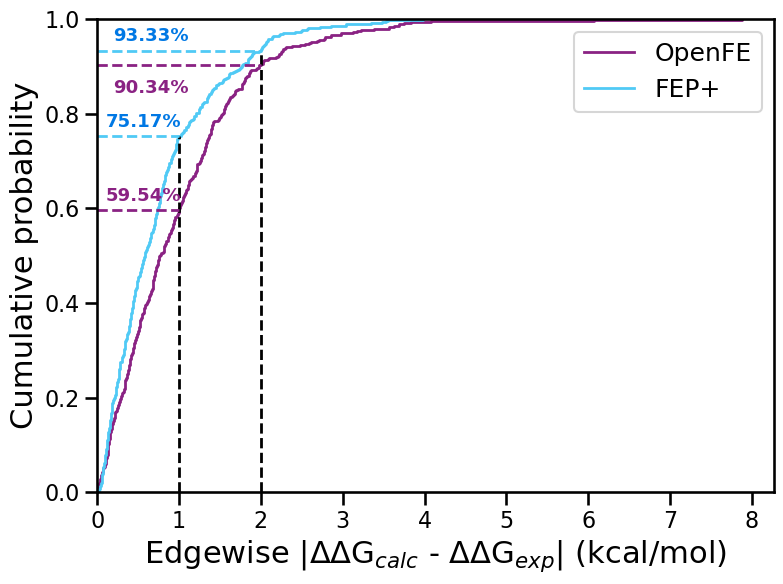

In [167]:
# plot the cdf of the absolute edgewise errors for openfe and fep+
# make the dataframe
fig, ax = plt.subplots(figsize=(8, 6))

openfe_abs_ddg = np.abs(overlap_df_final["DDG_bind (kcal/mol)"] - overlap_df_final["exp DDG (kcal/mol)"])
fep_plus_ddg = overlap_df_final["FEP+ Bennett ddG (kcal/mol)"]
fep_plus_abs_ddg = np.abs(fep_plus_ddg - overlap_df_final["exp DDG (kcal/mol)"])
sns.ecdfplot(x=openfe_abs_ddg, label="OpenFE", color=openfe_color, linewidth=2, ax=ax)
sns.ecdfplot(x=fep_plus_abs_ddg, label="FEP+", color=fep_plus_color, linewidth=2, ax=ax)
# calculate the probability of being below 1 kcal/mol for both
prob_below_1_openfe = np.sum(openfe_abs_ddg < 1) / len(openfe_abs_ddg)
prob_below_1_fep_plus = np.sum(fep_plus_abs_ddg < 1) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 1 kcal/mol: {prob_below_1_openfe:.2%}")
print(f"Probability of FEP+ being below 1 kcal/mol: {prob_below_1_fep_plus:.2%}")
# add a line at 1 kcal/mol for both
ax.axvline(x=1, ymax=prob_below_1_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_openfe, prob_below_1_openfe], color=openfe_color, linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_fep_plus, prob_below_1_fep_plus], color=fep_plus_color, linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.1, prob_below_1_openfe + 0.02, f"{prob_below_1_openfe:.2%}", color=openfe_color, fontsize=13, weight='bold')
ax.text(0.1, prob_below_1_fep_plus + 0.02, f"{prob_below_1_fep_plus:.2%}", color=fep_plus_text_color, fontsize=13, weight='bold')
# same again for 2  kcal/mol
prob_below_2_openfe = np.sum(openfe_abs_ddg < 2) / len(openfe_abs_ddg)
prob_below_2_fep_plus = np.sum(fep_plus_abs_ddg < 2) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 2 kcal/mol: {prob_below_2_openfe:.0%}")
print(f"Probability of FEP+ being below 2 kcal/mol: {prob_below_2_fep_plus:.0%}")
# stop the line at the higher probability curve 

ax.axvline(x=2, ymax=prob_below_2_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_openfe, prob_below_2_openfe], color=openfe_color, linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_fep_plus, prob_below_2_fep_plus], color=fep_plus_color, linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.2, prob_below_2_openfe - 0.06, f"{prob_below_2_openfe:.2%}", color=openfe_color, fontsize=13, weight='bold')
ax.text(0.2, prob_below_2_fep_plus + 0.02, f"{prob_below_2_fep_plus:.2%}", color=fep_plus_text_color, fontsize=13, weight='bold')

plt.legend(fontsize=18)
plt.xlim(left=0.0)
plt.ylabel("Cumulative probability", fontsize=22)
plt.tick_params(labelsize=16)
plt.xlabel(r"Edgewise |$\Delta\Delta$G$_{calc}$ - $\Delta\Delta$G$_{exp}$| (kcal/mol)", fontsize=22)
plt.tight_layout()
plt.savefig("edgewise_abs_ddg_eror_ecdf_vs_fep.png", bbox_inches="tight", dpi=300)

Probability of OpenFE - FEP+ being below 1 kcal/mol: 67.36%
Probability of OpenFE - FEP+ being below 2 kcal/mol: 91%
Probability of OpenFE - FEP+ being below 0.5 kcal/mol: 41.84%


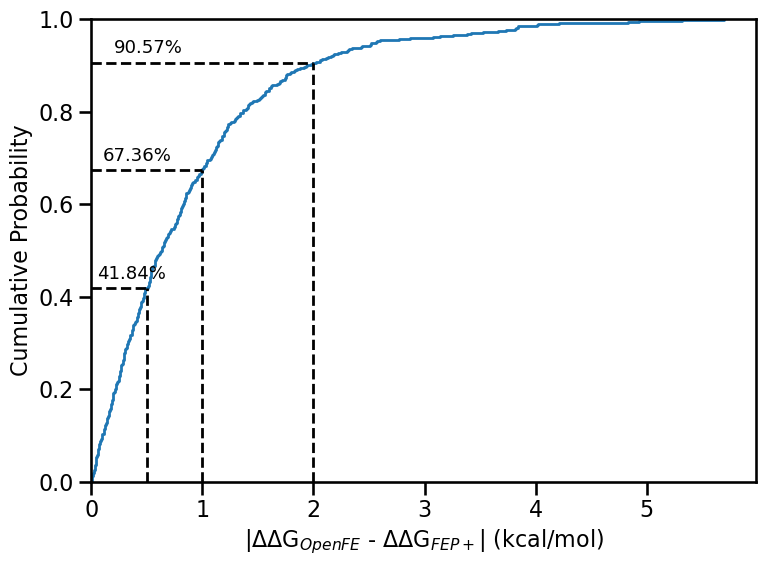

In [64]:
# plot an ecdf of the difference between the openfe and fep+ ddg values
fig, ax = plt.subplots(figsize=(8, 6))

openfe_ddg = overlap_df_final["DDG_bind (kcal/mol)"]
fep_plus_ddg = overlap_df_final["FEP+ Bennett ddG (kcal/mol)"]
ddg_diff = np.abs(openfe_ddg - fep_plus_ddg)
sns.ecdfplot(x=ddg_diff, linewidth=2, ax=ax)
# set y axis title
ax.set_ylabel("Cumulative Probability", fontsize=16)
# set x axis title
ax.set_xlabel(r"|$\Delta\Delta$G$_{OpenFE}$ - $\Delta\Delta$G$_{FEP+}$| (kcal/mol)", fontsize=16)
# work out the probability of being below 1 kcal/mol
prob_below_1 = np.sum(ddg_diff < 1) / len(ddg_diff)
print(f"Probability of OpenFE - FEP+ being below 1 kcal/mol: {prob_below_1:.2%}")
# add a line at 1 kcal/mol
ax.axvline(x=1, ymax=prob_below_1, color='k', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1, prob_below_1], color='k', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.1, prob_below_1 + 0.02, f"{prob_below_1:.2%}", color='k', fontsize=13)
# work out the probability of being below 2 kcal/mol
prob_below_2 = np.sum(ddg_diff < 2) / len(ddg_diff)
print(f"Probability of OpenFE - FEP+ being below 2 kcal/mol: {prob_below_2:.0%}")
# add a line at 2 kcal/mol
ax.axvline(x=2, ymax=prob_below_2, color='k', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2, prob_below_2], color='k', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.2, prob_below_2 + 0.02, f"{prob_below_2:.2%}", color='k', fontsize=13)
# workout the probability of being below 0.5 kcal/mol
prob_below_05 = np.sum(ddg_diff < 0.5) / len(ddg_diff)
print(f"Probability of OpenFE - FEP+ being below 0.5 kcal/mol: {prob_below_05:.2%}")
# add a line at 0.5 kcal/mol    
ax.axvline(x=0.5, ymax=prob_below_05, color='k', linestyle='--', linewidth=2)
ax.plot([0, 0.5], [prob_below_05, prob_below_05], color='k', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.05, prob_below_05 + 0.02, f"{prob_below_05:.2%}", color='k', fontsize=13)
# set the x and y tick font size
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlim(left=0.0)
plt.tight_layout()
plt.savefig("edgewise_ddg_diff_ecdf.png", bbox_inches="tight", dpi=300)

In [69]:
# calculate the mean signed and unsigned difference between the openfe and fep+ ddg values
mean_signed_diff = np.mean(openfe_ddg - fep_plus_ddg)
mean_unsigned_diff = np.mean(np.abs(openfe_ddg - fep_plus_ddg))
rms_diff = np.sqrt(np.mean((openfe_ddg - fep_plus_ddg)**2))
print(f"RMS difference between OpenFE and FEP+: {rms_diff:.2f} kcal/mol")
print(f"Mean signed difference between OpenFE and FEP+: {mean_signed_diff:.2f} kcal/mol")
print(f"Mean unsigned difference between OpenFE and FEP+: {mean_unsigned_diff:.2f} kcal/mol")

RMS difference between OpenFE and FEP+: 1.27 kcal/mol
Mean signed difference between OpenFE and FEP+: 0.14 kcal/mol
Mean unsigned difference between OpenFE and FEP+: 0.89 kcal/mol


In [71]:
# calculate the rmse and mue against the experimental values for all openfe edges
all_openfe_edges_exp = all_openfe_edges[all_openfe_edges["exp DDG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
# calculate the sample RMSE and MUE
openfe_rmse = np.sqrt(np.mean((all_openfe_edges_exp["DDG_bind (kcal/mol)"] - all_openfe_edges_exp["exp DDG (kcal/mol)"]) ** 2))
openfe_mue = np.mean(np.abs(all_openfe_edges_exp["DDG_bind (kcal/mol)"] - all_openfe_edges_exp["exp DDG (kcal/mol)"]))
# bootstrap the RMSE and MUE
nboots = 1000
rmse_samples, mue_samples = np.zeros(nboots), np.zeros(nboots)
for i in range(nboots):
    bootstrapped_df = all_openfe_edges_exp.sample(n=len(all_openfe_edges_exp), replace=True)
    rmse_samples[i] = np.sqrt(np.mean((bootstrapped_df["DDG_bind (kcal/mol)"] - bootstrapped_df["exp DDG (kcal/mol)"]) ** 2))
    mue_samples[i] = np.mean(np.abs(bootstrapped_df["DDG_bind (kcal/mol)"] - bootstrapped_df["exp DDG (kcal/mol)"]))
# calculate the 95% confidence intervals
rmse_lower = np.percentile(rmse_samples, 2.5)
rmse_upper = np.percentile(rmse_samples, 97.5)
mue_lower = np.percentile(mue_samples, 2.5)
mue_upper = np.percentile(mue_samples, 97.5)
print(f"OpenFE RMSE: {openfe_rmse:.2f} kcal/mol (95% CI: {rmse_lower:.2f} - {rmse_upper:.2f})")
print(f"OpenFE MUE: {openfe_mue:.2f} kcal/mol (95% CI: {mue_lower:.2f} - {mue_upper:.2f})")

OpenFE RMSE: 1.37 kcal/mol (95% CI: 1.30 - 1.45)
OpenFE MUE: 1.05 kcal/mol (95% CI: 1.00 - 1.10)


In [72]:
# get the number of edges with experimental data
num_exp_edges = len(all_openfe_edges_exp)
print(f"Number of OpenFE edges with experimental data: {num_exp_edges}")

Number of OpenFE edges with experimental data: 1181


In [73]:
# workout the number of sub kcal/mol error predictions
num_sub_kcal_errors = (abs((all_openfe_edges_exp["DDG_bind (kcal/mol)"] - all_openfe_edges_exp["exp DDG (kcal/mol)"])) < 1).sum()
print(f"Number of OpenFE edges with sub 1 kcal/mol error: {num_sub_kcal_errors/len(all_openfe_edges_exp) * 100}%")


Number of OpenFE edges with sub 1 kcal/mol error: 56.39288738357324%


In [74]:
def calculate_rmse_and_mue_overlap(df):
    """
    Calculate RMSE and MUE for OpenFE and FEP+ using the overlap dataframe or a subset of it.
    """
    results = []
    openfe_values = df["DDG_bind (kcal/mol)"].values
    fep_plus_values = df["FEP+ Bennett ddG (kcal/mol)"].values
    exp_values = df["exp DDG (kcal/mol)"].values
    for calculated, label in zip([openfe_values, fep_plus_values], ["OpenFE", "FEP+"]):
        for stat in ["RMSE", "MUE"]:
            s = bootstrap_statistic(y_true=exp_values, y_pred=calculated, statistic=stat)
            results.append({
                "Protocol": label,
                "Stat": stat,
                "MLE": s["mle"],
                "Low": s["low"],
                "High": s["high"]
            })
    return pd.DataFrame(results)
    

overall_stats = calculate_rmse_and_mue_overlap(overlap_df_final)
print(overall_stats)

  Protocol  Stat       MLE       Low      High
0   OpenFE  RMSE  1.320035  1.171013  1.474269
1   OpenFE   MUE  0.986337  0.903918  1.067679
2     FEP+  RMSE  1.017799  0.936128  1.101628
3     FEP+   MUE  0.764467  0.700313  0.831385


In [75]:
from scipy.stats import wilcoxon
stat, p = wilcoxon(openfe_ddg, fep_plus_ddg)
# any significant difference using a paired wilcoxon test so we don't have to assume normally distributed differences
if p < 0.05:
    print("There is a significant difference between OpenFE and FEP+ DDG values.")
else:
    print("There is no significant difference between OpenFE and FEP+ DDG values.")
print(f"Wilcoxon signed-rank test statistic: {stat}, p-value: {p}")

There is a significant difference between OpenFE and FEP+ DDG values.
Wilcoxon signed-rank test statistic: 40302.0, p-value: 0.0067040272788853284


In [76]:
# how many edges are charge changes
overlap_df_final[overlap_df_final["alchemical_charge_difference"] != 0.0]

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_smallest_overlap,failed,system group,system name,DDG_bind (kcal/mol),stdev DDG_bind (kcal/mol),FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
1,39charg,34,0.0,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,0.206549,NaN,charge_annihilation_set,cdk2,-2.734255,0.244470,-1.898499,0.098677,-2.01,0.34
2,39charg,25,0.0,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,0.198287,NaN,charge_annihilation_set,cdk2,-2.866959,0.355077,-1.348801,0.092692,-1.54,0.37
6,9,4charg,0.0,-1,0.614286,0.072997,0.874647,0.961433,23,3,...,0.170496,NaN,charge_annihilation_set,dlk,0.977934,0.091531,-0.415100,0.075213,-0.41,0.21
7,17charg,18,0.0,1,0.614286,0.123677,0.837373,0.812274,24,4,...,0.190207,NaN,charge_annihilation_set,dlk,-0.087894,0.081369,-0.183899,0.083189,-0.15,0.25
11,21,30charg,0.0,-1,0.614286,0.149241,0.724080,0.732328,37,6,...,0.200005,NaN,charge_annihilation_set,egfr,2.259027,0.181022,1.050000,0.100000,0.80,0.35
12,21,27chargR,0.0,-1,0.614286,0.135585,0.696112,0.832751,37,6,...,0.206002,NaN,charge_annihilation_set,egfr,1.982641,0.168933,0.190000,0.090000,0.25,0.34
15,19charg,20,0.0,-1,0.614286,0.023911,0.976154,0.885372,21,0,...,0.206997,NaN,charge_annihilation_set,ephx2,-1.974215,0.538446,-3.172100,0.258688,-2.59,0.71
16,47charg,33,0.0,-1,0.614286,0.140696,0.911633,0.491555,25,3,...,0.225573,NaN,charge_annihilation_set,ephx2,-0.686979,0.314083,-0.610399,0.124347,-0.77,0.63
21,6,5charg,0.0,-1,0.614286,0.167414,0.745609,0.910471,27,0,...,0.156882,NaN,charge_annihilation_set,irak4_s2,-2.099726,0.203072,-3.072998,0.094204,-3.32,0.68
22,17charg,18,0.0,1,0.614286,0.046374,0.952098,0.901998,32,1,...,0.196707,NaN,charge_annihilation_set,irak4_s2,-2.133127,0.166192,-2.658703,0.104952,-2.89,0.68


In [77]:
charged_overlap_df = overlap_df_final[overlap_df_final["alchemical_charge_difference"] != 0.0].copy(deep=True).reset_index(drop=True)
charged_stats = calculate_rmse_and_mue_overlap(charged_overlap_df)
print(charged_stats)

  Protocol  Stat       MLE       Low      High
0   OpenFE  RMSE  1.646792  1.295121  2.002460
1   OpenFE   MUE  1.385378  1.082405  1.718585
2     FEP+  RMSE  1.391316  1.051091  1.721376
3     FEP+   MUE  1.063989  0.763715  1.372846


In [78]:
neutral_overlap_df = overlap_df_final[overlap_df_final["alchemical_charge_difference"] == 0.0].copy(deep=True).reset_index(drop=True)
neutral_stats = calculate_rmse_and_mue_overlap(neutral_overlap_df)
print(neutral_stats)

  Protocol  Stat       MLE       Low      High
0   OpenFE  RMSE  1.291552  1.156877  1.466973
1   OpenFE   MUE  0.955718  0.870818  1.043448
2     FEP+  RMSE  0.983294  0.895291  1.075120
3     FEP+   MUE  0.741484  0.679506  0.803023


In [79]:
# is there a significant difference between the charged and neutral edges for openfe
# test using t-test
from scipy.stats import ttest_ind
charged_errors = abs(charged_overlap_df["DDG_bind (kcal/mol)"] - charged_overlap_df["exp DDG (kcal/mol)"])
neutral_errors = abs(neutral_overlap_df["DDG_bind (kcal/mol)"] - neutral_overlap_df["exp DDG (kcal/mol)"])
stat, p = ttest_ind(charged_errors, neutral_errors, equal_var=True, alternative='greater')
print(p)
if p < 0.05:
    print("There is a significant difference between charged and neutral edges for OpenFE.")
else:
    print("There is no significant difference between charged and neutral edges for OpenFE.")

0.004258713733901184
There is a significant difference between charged and neutral edges for OpenFE.


In [81]:
# do the same check for fep+
charged_errors_fep = abs(charged_overlap_df["FEP+ Bennett ddG (kcal/mol)"] - charged_overlap_df["exp DDG (kcal/mol)"])
neutral_errors_fep = abs(neutral_overlap_df["FEP+ Bennett ddG (kcal/mol)"] - neutral_overlap_df["exp DDG (kcal/mol)"])
stat, p = ttest_ind(charged_errors_fep, neutral_errors_fep, equal_var=True, alternative='greater')
print(p)
if p < 0.05:
    print("There is a significant difference between charged and neutral edges for FEP+.")
else:
    print("There is no significant difference between charged and neutral edges for FEP+.")

0.004971784444809055
There is a significant difference between charged and neutral edges for FEP+.


In [84]:
# sort the edges by the absolute error of the openfe ddg values
overlap_df_final["abs_error"] = np.abs(overlap_df_final["DDG_bind (kcal/mol)"] - overlap_df_final["exp DDG (kcal/mol)"])
overlap_df_final = overlap_df_final.sort_values("abs_error", ascending=False).reset_index(drop=True)
overlap_df_final.head(10)

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,failed,system group,system name,DDG_bind (kcal/mol),stdev DDG_bind (kcal/mol),FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol),abs_error
0,cmpd 9,cmpd 7,0.332871,0,1.000000,0.131111,0.648818,0.684838,17,3,...,NaN,water_set,hsp90_kung,6.384634,0.231914,1.070699,0.082493,1.24,0.27,7.874634
1,CHEMBL3402741_400,CHEMBL3402764_90,0.105399,0,1.000000,0.233418,0.623520,0.544750,24,12,...,NaN,merck,cmet,5.189113,0.547519,1.180900,0.139666,0.96,0.28,6.072897
2,227,289,0.670320,0,1.000000,0.237764,0.934585,0.362258,25,3,...,NaN,merck,hif2a,3.919198,0.444491,0.110001,0.038761,0.02,0.09,4.074644
3,23484,23485,0.904837,0,1.000000,0.030766,1.000000,0.829348,36,0,...,NaN,jacs_set,ptp1b,0.574197,0.111405,-2.502800,0.209866,-2.64,0.39,3.834197
4,24 pose 2,20,0.223130,0,1.000000,0.301581,0.517245,0.159003,25,9,...,NaN,water_set,chk1,6.849426,1.478548,1.919970,0.281119,2.28,0.63,3.754426
5,26charg,32,0.000000,1,0.714286,0.179743,0.724728,1.000000,27,0,...,NaN,charge_annihilation_set,ptp1b,-7.774565,1.700073,-2.077499,0.139455,-1.86,0.41,3.684566
6,21,30charg,0.000000,-1,0.614286,0.149241,0.724080,0.732328,37,6,...,NaN,charge_annihilation_set,egfr,2.259027,0.181022,1.050000,0.100000,0.80,0.35,3.629027
7,17r,17n,0.904837,0,1.000000,0.026276,0.960025,0.842437,28,0,...,NaN,miscellaneous_set,galectin,-3.729559,0.115364,-0.473559,0.070477,-0.38,0.10,3.565067
8,4,3,0.740818,0,1.000000,0.298636,0.808121,0.394358,14,3,...,NaN,fragments,p38,4.873849,0.442751,2.003679,0.160350,2.29,0.40,3.563849
9,3,jmb2009-4,0.110803,0,1.000000,0.321150,0.411165,0.233108,19,8,...,NaN,charge_annihilation_set,thrombin,-9.255309,1.420007,-7.745995,0.120043,-7.72,0.52,3.385309


In [85]:
openfe_error = overlap_df_final["abs_error"]
exp_ddg = overlap_df_final["exp DDG (kcal/mol)"]
fep_error = abs(exp_ddg - overlap_df_final["FEP+ Bennett ddG (kcal/mol)"])
overlap_high_error = overlap_df_final[(fep_error > 1.5) & (openfe_error > 1.5)].copy(deep=True).reset_index(drop=True)
# overlap_high_error
overlap_openfe_better = overlap_df_final[openfe_error + 1.0 < fep_error].copy(deep=True).reset_index(drop=True)
overlap_fep_plus_better = overlap_df_final[fep_error + 1.0 < openfe_error]


In [86]:
overlap_openfe_better

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,failed,system group,system name,DDG_bind (kcal/mol),stdev DDG_bind (kcal/mol),FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol),abs_error
0,17charg,5charg,0.074274,0,1.000000,0.169549,0.549579,0.997435,26,7,...,NaN,charge_annihilation_set,irak4_s2,-1.740261,0.549262,-2.846001,0.115958,-2.83,0.54,2.240261
1,17charg,14,0.000000,1,0.614286,0.043588,0.973313,0.797078,32,1,...,NaN,charge_annihilation_set,irak4_s2,-1.796949,0.095302,-3.547302,0.079206,-3.25,0.68,1.796949
2,19,27,0.472367,0,1.000000,0.161751,0.839939,0.564509,25,1,...,NaN,merck,cdk8,0.654890,2.269527,-1.259800,0.373930,-1.40,0.37,1.618279
3,b1i5c,b1i5b,0.904837,0,1.000000,0.065722,0.938781,0.645365,33,0,...,NaN,mcs_docking_set,renin,2.644487,0.254143,-0.123299,0.110476,-0.10,0.11,1.215377
4,19charg,20,0.000000,-1,0.614286,0.023911,0.976154,0.885372,21,0,...,NaN,charge_annihilation_set,ephx2,-1.974215,0.538446,-3.172100,0.258688,-2.59,0.71,1.074214
5,6,14,0.272532,0,1.000000,0.121166,0.718486,1.000000,26,1,...,NaN,charge_annihilation_set,irak4_s2,-2.419084,0.234183,-3.828598,0.059175,-3.74,0.57,0.819085
6,cmpd 2 (methyl),cmpd 3 (Allyl),0.818731,0,1.000000,0.139277,0.911597,0.677539,22,0,...,NaN,water_set,brd4,1.754987,0.099368,-0.075160,0.072814,-0.16,0.15,0.745013
7,6d,7d,0.818731,0,1.000000,0.039416,0.979379,0.858394,26,0,...,NaN,water_set,scyt_dehyd,-6.567299,0.199550,-2.362220,0.171968,-2.25,0.44,0.721627
8,18charg,16charg,0.670320,0,1.000000,0.141745,0.828898,0.720819,19,4,...,NaN,charge_annihilation_set,jak1,1.273767,0.305052,-1.248400,0.227266,-1.57,0.94,0.513767
9,19charg,28charg,0.904837,0,1.000000,0.009149,1.000000,0.925315,29,0,...,NaN,charge_annihilation_set,irak4_s3,0.627291,0.285256,-0.670799,0.145930,-0.81,0.61,0.472710


In [87]:
# load all the ligands so we can visualise some of the transformations and calculate some metrics
import pathlib
from rdkit import Chem
all_ligands = {}
name_conversions = {
    "41 flip": "41-flip",
    "40 flip": "40-flip",
    "38 flip": "38-flip",
    "30 flip": "30-flip",
    "43 flip": "43-flip",
    "47 flip": "47-flip",
    "48 flip": "48-flip",
    "46 flip": "46-flip",
    "36 out": "36o",
    "37 out": "37o",
    "38 out": "38o",
    "39 out": "39o",
    "28 out": "28o",
    "CHEMBL3402756_2.7 redocked": "CHEMBL3402756_2.7_redocked",
    "CHEMBL3402757_6.5 redocked" : "CHEMBL3402757_6.5_redocked",
    "CHEMBL3402758_10 redocked": "CHEMBL3402758_10_redocked",
    "CHEMBL3402760_1 redocked":"CHEMBL3402760_1_redocked",
    "CHEMBL3402762_1 redocked": "CHEMBL3402762_1_redocked",
    "CHEMBL3402759_5.7 redocked": "CHEMBL3402759_5.7_redocked",
    "CHEMBL3402761_1 redocked": "CHEMBL3402761_1_redocked",
    "Example 22":"Example-22",
    "Example 23": "Example-23",
    "Example 14": "Example-14",
    "Example 9": "Example-9",
    "SHP099-1 Example 7": "SHP099-1-Example-7",
    "Example 28": "Example-28",
    "Example 24": "Example-24",
    "Example 26": "Example-26",
    "Example 6": "Example-6",
    "Example 1": "Example-1",
    "Example 30": "Example-30",
    "Example 8": "Example-8",
    "Example 29": "Example-29",
    "Example 2": "Example-2",
    "Example 25": "Example-25",
    "Example 4": "Example-4",
    "Example 3": "Example-3",
    "Example 27": "Example-27",
    "Example 5": "Example-5",
    "9 flip": "9-flip",
}
key_to_ligand = {}
base_data_folder = pathlib.Path("/Users/joshua/Documents/Software/IndustryBenchmarks2024/industry_benchmarks/input_structures/prepared_structures")
for folder in base_data_folder.glob("*"):
    if folder.is_dir() and folder != "template":
        for target_ligs in folder.glob("*/ligands.sdf"):
            # load the ligands
            supplier = Chem.SDMolSupplier(target_ligs, removeHs=False)
            for lig in supplier:
                name = lig.GetProp("_Name")
                if name in name_conversions:
                    name = name_conversions[name]
                all_ligands[(name, target_ligs.parent.name, folder.name)] = Chem.GetFormalCharge(lig)
                key_to_ligand[(name, target_ligs.parent.name, folder.name)] = lig

In [88]:
# draw the kartograf mappings for an edge using the same settings as the plan networks script 
# from the industry benchmarks repo
from gufe import SmallMoleculeComponent
import kartograf
from kartograf.filters import (
    filter_ringbreak_changes,
    filter_ringsize_changes,
    filter_whole_rings_only,
)
from rdkit.Chem import Draw
grid_x, grid_y = 2, 1
from gufe.visualization.mapping_visualization import draw_mapping
def get_karto_mapping(liga, ligb, target, system):
    mapping_filters = [
            filter_ringbreak_changes,  # default
            filter_ringsize_changes,  # default
            filter_whole_rings_only,  # default
        ]
    mapper = kartograf.KartografAtomMapper(
        atom_map_hydrogens=True,
        additional_mapping_filter_functions=mapping_filters,
    )
    ligand_a = SmallMoleculeComponent(key_to_ligand[(liga, target, system)])
    ligand_b = SmallMoleculeComponent(key_to_ligand[(ligb, target, system)])
    mapping =  next(mapper.suggest_mappings(ligand_a, ligand_b))
    return mapping

def draw_mapping_karto(liga, ligb, target, system):
    d2d = Draw.rdMolDraw2D.MolDraw2DSVG(grid_x * 300, grid_y * 300, 300, 300)
    mapping = get_karto_mapping(liga, ligb, target, system)
    return draw_mapping(mapping._compA_to_compB, mapping.componentA.to_rdkit(), mapping.componentB.to_rdkit(), d2d)

In [89]:
from itertools import combinations
import networkx as nx
def is_scaffold_change(liga, ligb, target, system):
    """
    Check if the mapping between two ligands is a scaffold change.
    A scaffold change is defined here as a change where the dummy atoms are connected to the core via two bonds, which is an undefined change OpenFE.
    """
    mapping = get_karto_mapping(liga, ligb, target, system)
    # check if the mapping has any undefined changes, these are changes where the dummy atoms are connected to the core via two bonds
    for atom_map, end_ligand in zip([mapping.componentA_to_componentB, mapping.componentB_to_componentA], [mapping.componentA, mapping.componentB]):
        # track dummy atoms which are connected to core atoms
        dummy_core_connections = []
        # build a graph of only the dummy atoms so we can check for paths between them anchor atoms
        graph = nx.Graph()
        rd_mol = end_ligand.to_rdkit()
        for atom in rd_mol.GetAtoms():
            atom_idx = atom.GetIdx()
            if atom_idx not in atom_map:
                graph.add_node(atom_idx)
                # add edges to the graph for the dummy atoms
                for neighbor in atom.GetNeighbors():
                    neighbor_idx = neighbor.GetIdx()
                    if neighbor_idx not in atom_map:
                        graph.add_edge(atom_idx, neighbor_idx)
                    else:
                        # if the neighbor is in the mapping, then it is a core atom
                        dummy_core_connections.append((atom_idx, neighbor_idx))
        if len(dummy_core_connections) > 1:
            # if there is more than one dummy core connection check for paths between the dummy atoms which are connected to core atoms
            for (dummy_atom_a, _), (dummy_atom_b, _) in combinations(dummy_core_connections, 2):
                if nx.has_path(graph, dummy_atom_a, dummy_atom_b):
                    # if there is a path between the two dummy atoms then it is a scaffold change
                    return True
    return False
                




In [90]:
# test all edges and see if they are scaffold changes
scaffold_changes = []
for _, row in all_openfe_edges.iterrows():
    liga = row["ligand_A"]
    ligb = row["ligand_B"]
    target = row["system name"]
    system = row["system group"]
    if is_scaffold_change(liga, ligb, target, system):
        scaffold_changes.append((liga, ligb, target, system))

no mapping could be found, after applying filters!


In [93]:
# how many total scaffold changes are there run with OpenFE?
len(scaffold_changes)

54

In [94]:
# get a dataframe of the scaffold changes and calculate the RMSE error for the edge wise predictions and compare with the other predictions
import numpy as np
from cinnabar.stats import bootstrap_statistic
scaffold_change_data, no_scaffold_change_data = [], []
for _, row in all_openfe_edges.iterrows():
    liga = row["ligand_A"]
    ligb = row["ligand_B"]
    target = row["system name"]
    system = row["system group"]
    if (liga, ligb, target, system) in scaffold_changes:
        scaffold_change_data.append(row.to_dict())
    else:
        no_scaffold_change_data.append(row.to_dict())
# convert to dataframes
scaffold_change_df = pd.DataFrame(scaffold_change_data)
no_scaffold_change_df = pd.DataFrame(no_scaffold_change_data)
# calculate the RMSE for the edge wise predictions
def calculate_edge_rmse(df):
    ddg = df["DDG_bind (kcal/mol)"]
    exp_ddg = df["exp DDG (kcal/mol)"]
    stats = bootstrap_statistic(y_true=exp_ddg, y_pred=ddg, statistic="RMSE", nbootstrap=1000)
    return stats
# calculate the RMSE for the scaffold changes and no scaffold changes
scaffold_change_rmse = calculate_edge_rmse(scaffold_change_df)
no_scaffold_change_rmse = calculate_edge_rmse(no_scaffold_change_df)
print(f"Scaffold change RMSE: {scaffold_change_rmse['mle']:.2f} kcal/mol")
print(f"No scaffold change RMSE: {no_scaffold_change_rmse['mle']:.2f} kcal/mol")


Scaffold change RMSE: 2.20 kcal/mol
No scaffold change RMSE: 1.32 kcal/mol


In [95]:
no_scaffold_change_rmse

{'mle': 1.315900787430415,
 'stderr': 0.032643249631195755,
 'mean': 1.315964236957957,
 'low': 1.2502644614046785,
 'high': 1.3831096488000696}

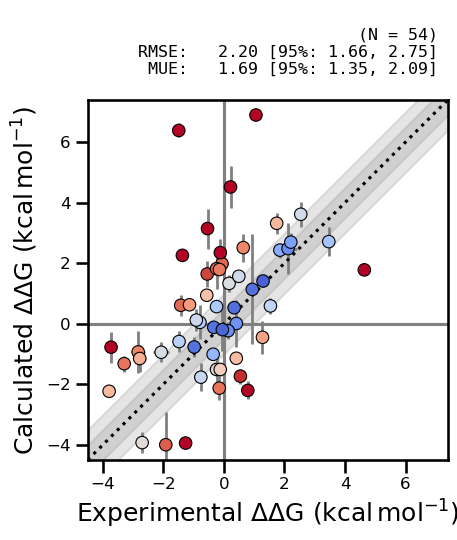

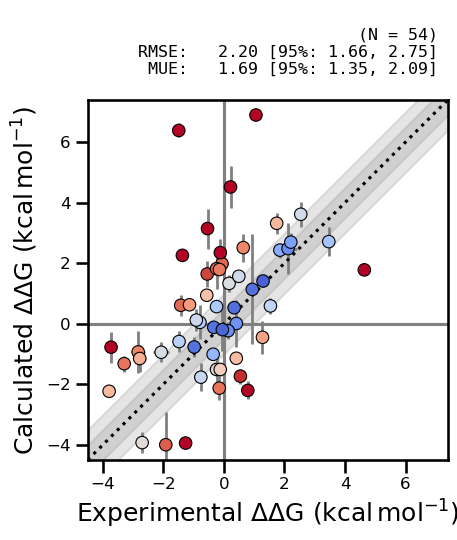

In [97]:
# plot the fused ring transformations using cinnabar
openfe_ddg = scaffold_change_df["DDG_bind (kcal/mol)"]
openfe_error = scaffold_change_df["stdev DDG_bind (kcal/mol)"]
exp_ddg = scaffold_change_df["exp DDG (kcal/mol)"]
exp_error = scaffold_change_df["exp dDDG (kcal/mol)"]
_master_plot(
    x=exp_ddg,
    y=openfe_ddg,
    xerr=exp_error,
    yerr=openfe_error,
    figsize=6,
    scatter_kwargs={"edgecolors": 'black', "linewidth":0.8},
    quantity=r"$\Delta \Delta$G",
    dpi=300,
    filename="scaffold_change_openfe_edgewise_predictions.png",
)

In [103]:
# function to automatically generate a pandas html report of the overlapping sets
# get the atom mapping exp openfe and FEP values and plot a bar chart to quickly look at the data and write to HTML
import base64
import numpy as np
def mol_to_html(interaction_image: str) -> str:
    raw_data = base64.b64encode(interaction_image.encode()).decode()
    return f"<img src='data:image/svg+xml;base64,{raw_data}'/>"

def create_overlap_report(df, fname):
    report_data = []
    for _, row in df.iterrows():
        system_name = row["system name"]
        system_group = row["system group"]
        liga = row["ligand_A"]
        ligb = row["ligand_B"]
        row_data = {"mapping": draw_mapping_karto(liga=liga, ligb=ligb, target=system_name, system=system_group), "Exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"]}
        # workout the openfe estimate
        row_data["OpenFE DDG"] = row["DDG_bind (kcal/mol)"]
        row_data["OpenFE dDDG"] = row["stdev DDG_bind (kcal/mol)"]
        row_data["FEP+ Bennett DDG"] = row["FEP+ Bennett ddG (kcal/mol)"]
        row_data["FEP+ Bennett dDDG"] = row["FEP+ Bennett std. error (kcal/mol)"]
        row_data["system group"] = system_group
        row_data["system name"] = system_name
        report_data.append(row_data)
    report = pd.DataFrame(report_data)
    report.to_html(fname, escape=False, formatters={"mapping": mol_to_html})
    

In [104]:
create_overlap_report(overlap_fep_plus_better, "fep_plus_better_edges.html")

In [105]:
create_overlap_report(overlap_openfe_better, "overlap_openfe_better_report.html")

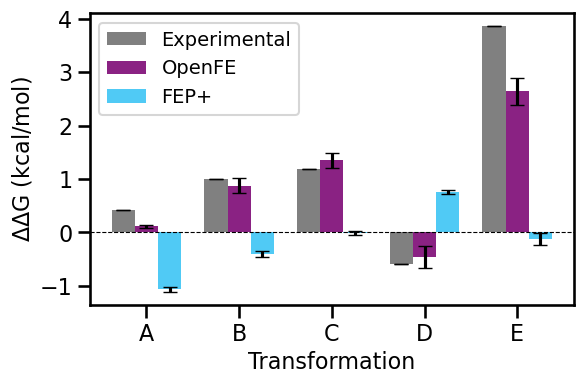

In [106]:
# plot the edges where openfe is better than FEP+ with simple hydrogen-to-methyl transformations
# edges chossen by manual inspection of the overlap_openfe_better dataframe
openfe_better_methyl_edges = [
    # system group, system name, ligand A, ligand B
    ("water_set", "hsp90_kung", "cmpd 15", "cmpd 12"),
    ("water_set", "brd4", "cmpd 2 (methyl)", "cmpd 6 (ethyl)"),
    ("fragments", "t4_lysozyme", "ethyl benzene", "ortho methyl ethyl benzene"),
    ("fragments", "t4_lysozyme", "o-xylene", "benzene"),
    ("mcs_docking_set", "renin", "b1i5c", "b1i5b")
]
# extract the rows from the overlap_openfe_better dataframe
methyl_edge_data = []
for system_group, system_name, liga, ligb in openfe_better_methyl_edges:
    row = overlap_openfe_better[(overlap_openfe_better["system group"] == system_group) & (overlap_openfe_better["system name"] == system_name) & (overlap_openfe_better["ligand_A"] == liga) & (overlap_openfe_better["ligand_B"] == ligb)]
    if len(row) == 1:
        methyl_edge_data.append(row.iloc[0].to_dict())
methyl_edge_df = pd.DataFrame(methyl_edge_data)
# plot the data as a bar chart with error bars
import matplotlib.pyplot as plt
x = np.arange(len(methyl_edge_df))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(6, 4))
# get the openfe values
openfe_ddg = methyl_edge_df["DDG_bind (kcal/mol)"].values
openfe_error = methyl_edge_df["stdev DDG_bind (kcal/mol)"].values
# get the fep+ values
fep_plus_ddg = methyl_edge_df["FEP+ Bennett ddG (kcal/mol)"].values
fep_plus_error = methyl_edge_df["FEP+ Bennett std. error (kcal/mol)"].values
# get the exp values
exp_ddg = methyl_edge_df["exp DDG (kcal/mol)"].values
exp_error = methyl_edge_df["exp dDDG (kcal/mol)"].values
# plot the bars
bars1 = ax.bar(x - width, exp_ddg, width, yerr=exp_error, label='Experimental', color='gray', capsize=5)
bars2 = ax.bar(x, openfe_ddg, width, yerr=openfe_error, label='OpenFE', color=openfe_color, capsize=5)
bars3 = ax.bar(x + width, fep_plus_ddg, width, yerr=fep_plus_error, label='FEP+', color=fep_plus_color, capsize=5)
# add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\Delta \Delta$G (kcal/mol)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(["A", "B", "C", "D", "E"], fontsize=16)
ax.set_xlabel("Transformation", fontsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("openfe_better_methyl_transformations.png", bbox_inches="tight", dpi=300)

In [107]:
# for each of these edges draw the kartograf mapping and save as svg files
for i, (system_group, system_name, liga, ligb) in enumerate(openfe_better_methyl_edges):
    mapping = draw_mapping_karto(liga=liga, ligb=ligb, target=system_name, system=system_group)
    with open(f"mapping_{i+1}_{system_group}_{system_name}_{liga}_to_{ligb}.svg", "w") as f:
        f.write(mapping)    

In [109]:
# load the bootstrap data
all_bootstrap_edges_openfe = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar4_edge_data.csv")
all_bootstrap_edges_openfe

,ligand_A,ligand_B,solvent_repeat_0_DG (kcal/mol),solvent_repeat_0_dDG (kcal/mol),solvent_repeat_0_smallest_overlap,solvent_repeat_1_DG (kcal/mol),solvent_repeat_1_dDG (kcal/mol),solvent_repeat_1_smallest_overlap,solvent_repeat_2_DG (kcal/mol),solvent_repeat_2_dDG (kcal/mol),...,complex_repeat_1_DG (kcal/mol),complex_repeat_1_dDG (kcal/mol),complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_smallest_overlap,partner_id,dataset_name,system group,system name
0,39charg,25,20.360247,0.477995,0.198963,20.390495,0.461825,0.200488,20.503254,0.483667,...,17.258927,0.779998,0.195608,17.934588,0.809891,0.198527,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
1,39charg,34,-18.515365,0.323653,0.197684,-18.401187,0.319921,0.196736,-18.425598,0.359356,...,-21.212537,0.461344,0.206534,-21.401634,0.579785,0.205918,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
2,34,25,26.902798,0.288979,0.141621,26.699658,0.327086,0.140087,26.756194,0.270871,...,27.472428,0.492906,0.111850,27.245596,0.513882,0.111561,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
3,9,4charg,-89.134348,0.462722,0.169842,-89.157175,0.439393,0.169260,-89.072765,0.420814,...,-88.072421,0.725085,0.171854,-88.127237,0.731602,0.171839,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk
4,17charg,18,-86.775465,0.447984,0.194129,-86.691162,0.450044,0.193655,-86.800853,0.465490,...,-86.782652,0.714112,0.191229,-86.897203,0.912997,0.188960,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,"10302 (1GJ7, no water pose)",11417 (no water pose),-6.970065,0.247761,0.230715,-6.963792,0.242146,0.230504,-7.013646,0.249333,...,-4.931593,0.240233,0.232638,-4.857858,0.276601,0.232368,Janssen,janssen_public/waterset_urokinase/results_data,water_set,urokinase
1141,7806 (no water pose),8696 (no water pose),17.974265,0.051898,0.132659,17.981820,0.052770,0.132870,17.980524,0.050186,...,17.950910,0.057768,0.126303,17.930662,0.058544,0.126105,Janssen,janssen_public/waterset_urokinase/results_data,water_set,urokinase
1142,"10302 (1GJ7, no water pose)",8696 (no water pose),-7.745691,0.087072,0.126017,-7.657672,0.082068,0.125539,-7.651216,0.089154,...,-4.515525,0.059641,0.103170,-4.767291,0.065005,0.105011,Janssen,janssen_public/waterset_urokinase/results_data,water_set,urokinase
1143,47,46,-10.541877,0.074403,0.143176,-10.440122,0.080975,0.142742,-10.576783,0.081566,...,-11.105152,0.138236,0.133004,-11.214751,0.152255,0.132207,NaN,NaN,merck,pfkfb3


In [110]:
all_openfe_edges

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,DDG_bind (kcal/mol),stdev DDG_bind (kcal/mol)
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,27.245596,0.113900,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2,0.456528,0.253792
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,-21.401634,0.074439,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2,-2.734255,0.244470
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,17.934588,0.088183,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2,-2.866959,0.355077
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,-3.680717,0.204893,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk,0.091906,0.229812
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,4.873596,0.068123,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk,-1.613313,0.121454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,5.025639,0.083096,47.049469,68.496689,0.104164,NaN,merck,pfkfb3,0.817963,0.325819
1177,65,29,0.704688,0,1.000000,0.155796,0.895401,0.484258,30,0,...,-83.240725,0.102459,29.012836,53.727703,0.160825,NaN,merck,pfkfb3,0.485801,0.245501
1178,29,64,0.778801,0,1.000000,0.155630,0.895401,0.462020,30,1,...,86.337561,0.101216,46.250511,68.017464,0.164021,NaN,merck,pfkfb3,-0.323246,0.434290
1179,47,46,0.548812,0,1.000000,0.202290,0.735485,0.305883,27,2,...,-11.214751,0.046477,43.071308,66.045006,0.131496,NaN,merck,pfkfb3,-0.649200,0.090989


In [111]:
# get all complex mbar errors and compare with the std between repeats and bootstrap errors
mbar_data = []
for system in all_openfe_edges["system group"].unique():
    system_df = all_openfe_edges[all_openfe_edges["system group"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["system name"].unique():
        target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
        bootstrap_target_df = all_bootstrap_edges_openfe[(all_bootstrap_edges_openfe["system group"] == system) & (all_bootstrap_edges_openfe["system name"] == target)]
        for _, row in target_df.iterrows():
            data = {
                "Standard deviation of repeates (kcal/mol)": np.std([row[f"complex_repeat_{i}_DG (kcal/mol)"] for i in range(3)], ddof=1),
                "Error type": "Analytical",
                "Error estimate (kcal/mol)": np.mean([row[f"complex_repeat_{i}_dDG (kcal/mol)"] for i in range(3)])
            }
            # get the bootstrap data
            boot_row = bootstrap_target_df[(bootstrap_target_df["ligand_A"] == row["ligand_A"]) & (bootstrap_target_df["ligand_B"] == row["ligand_B"])]
            if len(boot_row) == 1:
                data_boot = {
                    "Standard deviation of repeates (kcal/mol)": np.std([row[f"complex_repeat_{i}_DG (kcal/mol)"] for i in range(3)], ddof=1),
                    "Error type": "Bootstrap",
                    "Error estimate (kcal/mol)": np.mean([boot_row.iloc[0][f"complex_repeat_{i}_dDG (kcal/mol)"] for i in range(3)])
                }
                mbar_data.extend([data, data_boot])

pd.DataFrame(mbar_data)

,Standard deviation of repeates (kcal/mol),Error type,Error estimate (kcal/mol)
0,0.231123,Analytical,0.104893
1,0.231123,Bootstrap,0.494708
2,0.236961,Analytical,0.073085
3,0.236961,Bootstrap,0.560913
4,0.346987,Analytical,0.097274
...,...,...,...
2251,0.126607,Bootstrap,0.058994
2252,0.017092,Analytical,0.028018
2253,0.017092,Bootstrap,0.056770
2254,0.095470,Analytical,0.033607


In [112]:
pd.DataFrame(mbar_data).sort_values("Error estimate (kcal/mol)")

,Standard deviation of repeates (kcal/mol),Error type,Error estimate (kcal/mol)
2126,0.015830,Analytical,0.010182
826,0.106985,Analytical,0.011592
2127,0.015830,Bootstrap,0.012279
130,0.042242,Analytical,0.012948
132,0.008473,Analytical,0.013035
...,...,...,...
1447,1.994502,Bootstrap,2.752709
1439,1.600129,Bootstrap,2.924083
1473,2.366542,Bootstrap,3.065209
1436,1.743982,Analytical,3.450033


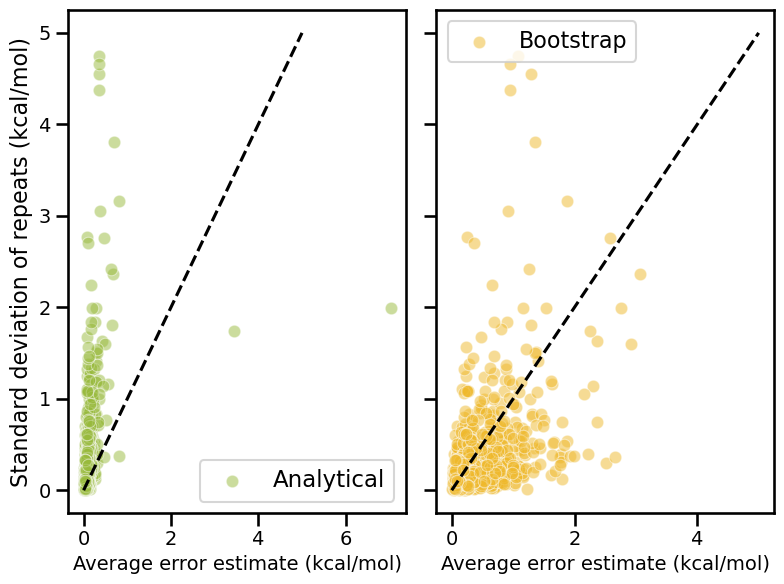

In [113]:
# scatter plot of the errors on two subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
mbar_data = pd.DataFrame(mbar_data)
analytical_data = mbar_data[mbar_data["Error type"] == "Analytical"].copy(deep=True)
bootstrap_data = mbar_data[mbar_data["Error type"] == "Bootstrap"]
sns.scatterplot(y=analytical_data["Standard deviation of repeates (kcal/mol)"].values, x=analytical_data["Error estimate (kcal/mol)"].values, label=r"Analytical", alpha=0.5, ax=ax[0], color="#98BA3C")
sns.scatterplot(y=bootstrap_data["Standard deviation of repeates (kcal/mol)"].values, x=bootstrap_data["Error estimate (kcal/mol)"].values, label=r"Bootstrap", alpha=0.5, ax=ax[1], color="#EFB92B")

ax[0].plot([0, 5], [0, 5], color="black", linestyle="--")
ax[1].plot([0, 5], [0, 5], color="black", linestyle="--")
ax[0].set_xlabel("Average error estimate (kcal/mol)", fontsize=14)
ax[1].set_xlabel("Average error estimate (kcal/mol)", fontsize=14)
ax[0].set_ylabel("Standard deviation of repeats (kcal/mol)", fontsize=16)
# set all ticks to fontsize 14
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
# plt.ylim( top=5)
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig("mbar_error_analysis.png", dpi=300, bbox_inches='tight')

In [131]:
# calculate the average pairwise tanimoto similarity for each system and add it to the overlap dataframe
from rdkit import DataStructs
from rdkit.Chem import AllChem

def get_average_tanimoto(df) -> float:
    """
    Get the average Morgan fingerprint Tanimoto similarity scores for all-to-all pairwise combinations.
    """
    # Morgan Fingerprint
    fpgen_morgan = AllChem.GetMorganGenerator(radius=3)
    scores = []
    system_name = df.iloc[0]["system name"]
    system_group = df.iloc[0]["system group"]
    print(system_name, system_group)
    # get all unique ligands in the dataframe
    ligands = df["ligand name"].unique()
    for i, ligand_a_name in enumerate(ligands):
        for j, ligand_b_name in enumerate(ligands):
            if i < j:
                # get all unique pairs of ligands
                ligand_a = key_to_ligand[(ligand_a_name, system_name, system_group)]
                ligand_b = key_to_ligand[(ligand_b_name, system_name, system_group)]
                # Get Fingerprint as bit vector
                fpA = fpgen_morgan.GetFingerprint(ligand_a)
                fpB = fpgen_morgan.GetFingerprint(ligand_b)
                # Get Tanimoto similarity
                morgan_fp_score = DataStructs.TanimotoSimilarity(fpA, fpB)
                scores.append(morgan_fp_score)
    return np.mean(scores)

In [132]:
average_tanimoto = []
for system in target_overlap_df["system group"].unique():
    system_df = target_overlap_df[target_overlap_df["system group"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["system name"].unique():
        target_df = dg_data_openfe[(dg_data_openfe["system group"] == system) & (dg_data_openfe["system name"] == target)].copy(deep=True).reset_index(drop=True)
        avg_tanimoto = get_average_tanimoto(target_df)
        average_tanimoto.append(avg_tanimoto)
target_overlap_df["average_tanimoto"] = average_tanimoto
target_overlap_df

cdk2 charge_annihilation_set
dlk charge_annihilation_set
egfr charge_annihilation_set
ephx2 charge_annihilation_set
irak4_s2 charge_annihilation_set
irak4_s3 charge_annihilation_set
itk charge_annihilation_set
jak1 charge_annihilation_set
jnk1 charge_annihilation_set
ptp1b charge_annihilation_set
thrombin charge_annihilation_set
tyk2 charge_annihilation_set
hsp90_2rings fragments
hsp90_single_ring fragments
jak2_set1 fragments
jak2_set2 fragments
liga fragments
mcl1 fragments
mup1 fragments
p38 fragments
t4_lysozyme fragments
bace jacs_set
cdk2 jacs_set
jnk1 jacs_set
mcl1 jacs_set
p38 jacs_set
ptp1b jacs_set
thrombin jacs_set
tyk2 jacs_set
bace_ciordia_prospective janssen_bace
bace_p3_arg368_in janssen_bace
ciordia_retro janssen_bace
keranen_p2 janssen_bace
hne mcs_docking_set
renin mcs_docking_set
cdk8 merck
cmet merck
eg5 merck
hif2a merck
shp2 merck
syk merck
tnks2 merck
pfkfb3 merck
btk miscellaneous_set
cdk8 miscellaneous_set
faah miscellaneous_set
galectin miscellaneous_set
hiv1_

,system group,system name,Overlap %,OpenFE Edges,Overlap edges,average_tanimoto
0,charge_annihilation_set,cdk2,100.000000,3,3,0.768556
1,charge_annihilation_set,dlk,83.333333,6,5,0.553756
2,charge_annihilation_set,egfr,71.428571,7,5,0.668740
3,charge_annihilation_set,ephx2,100.000000,4,4,0.646448
4,charge_annihilation_set,irak4_s2,100.000000,7,7,0.691506
5,charge_annihilation_set,irak4_s3,100.000000,4,4,0.710826
6,charge_annihilation_set,itk,100.000000,5,5,0.681054
7,charge_annihilation_set,jak1,71.428571,7,5,0.504241
8,charge_annihilation_set,jnk1,100.000000,2,2,0.697517
9,charge_annihilation_set,ptp1b,100.000000,3,3,0.682451
